# I. Camera Calibration

In [17]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

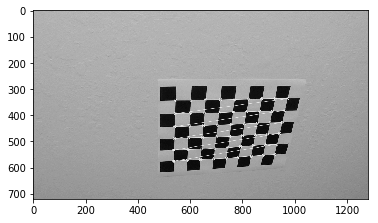

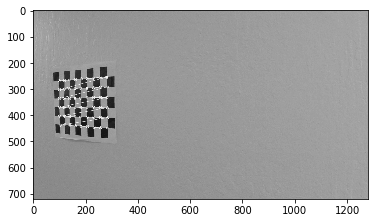

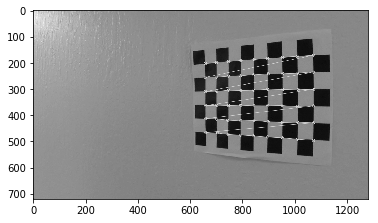

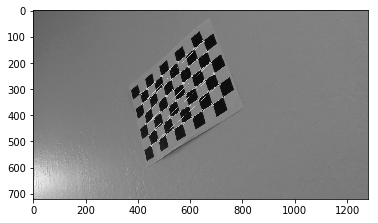

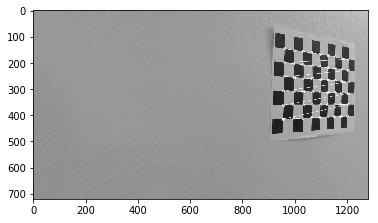

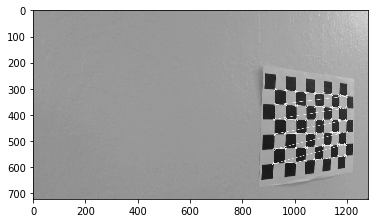

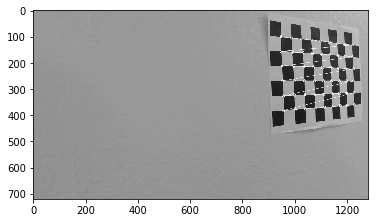

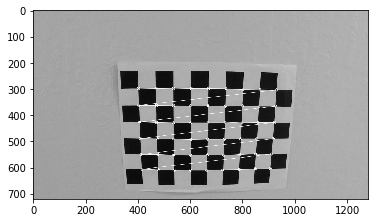

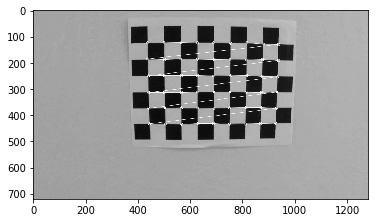

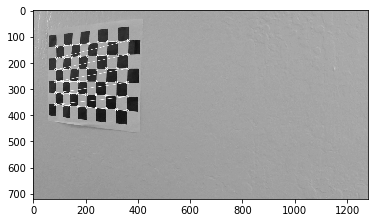

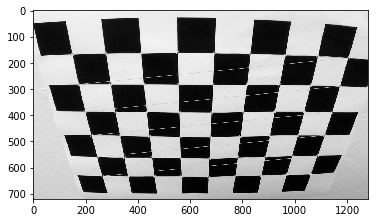

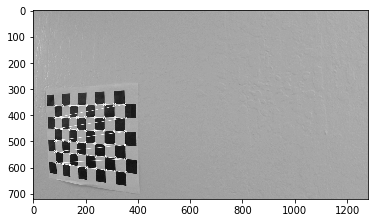

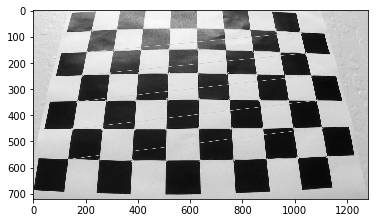

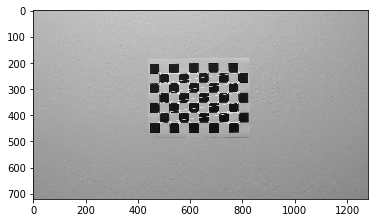

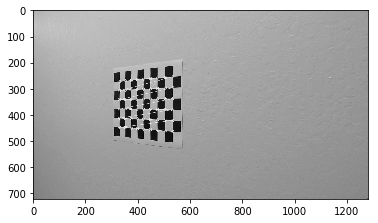

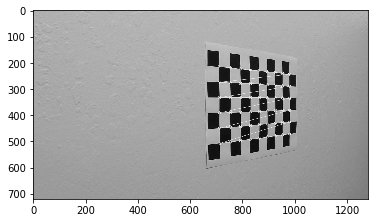

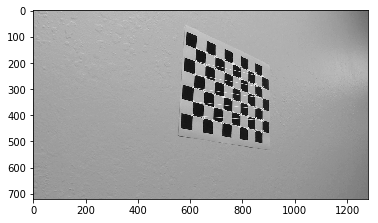

In [18]:
# Object points expected (0, 0, 0), (1, 0, 0), (2, 0, 0)...
object_point_grid = np.zeros((6*9, 3), np.float32)
object_point_grid[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Buffer for object points and image points
object_points = []
image_points = []

# Get the calibration imagery
calibration_images = glob.glob('camera_cal/calibration*.jpg')

# Accumulate the image points and display calibration images with corners identified
for calibration_image_path in calibration_images:
    calibration_image = cv2.imread(calibration_image_path)
    calibration_image_grayscaled = cv2.cvtColor(calibration_image, cv2.COLOR_BGR2GRAY)
    
    ok, chessboard_corners = cv2.findChessboardCorners(calibration_image_grayscaled, (9, 6), None)
    
    if ok:
        object_points.append(object_point_grid)
        image_points.append(chessboard_corners)
        
        calibration_image_with_corners = cv2.drawChessboardCorners(
            calibration_image_grayscaled,
            (9, 6),
            chessboard_corners,
            ok
        )
        plt.imshow(calibration_image_with_corners, cmap='gray')
        plt.figure()
        

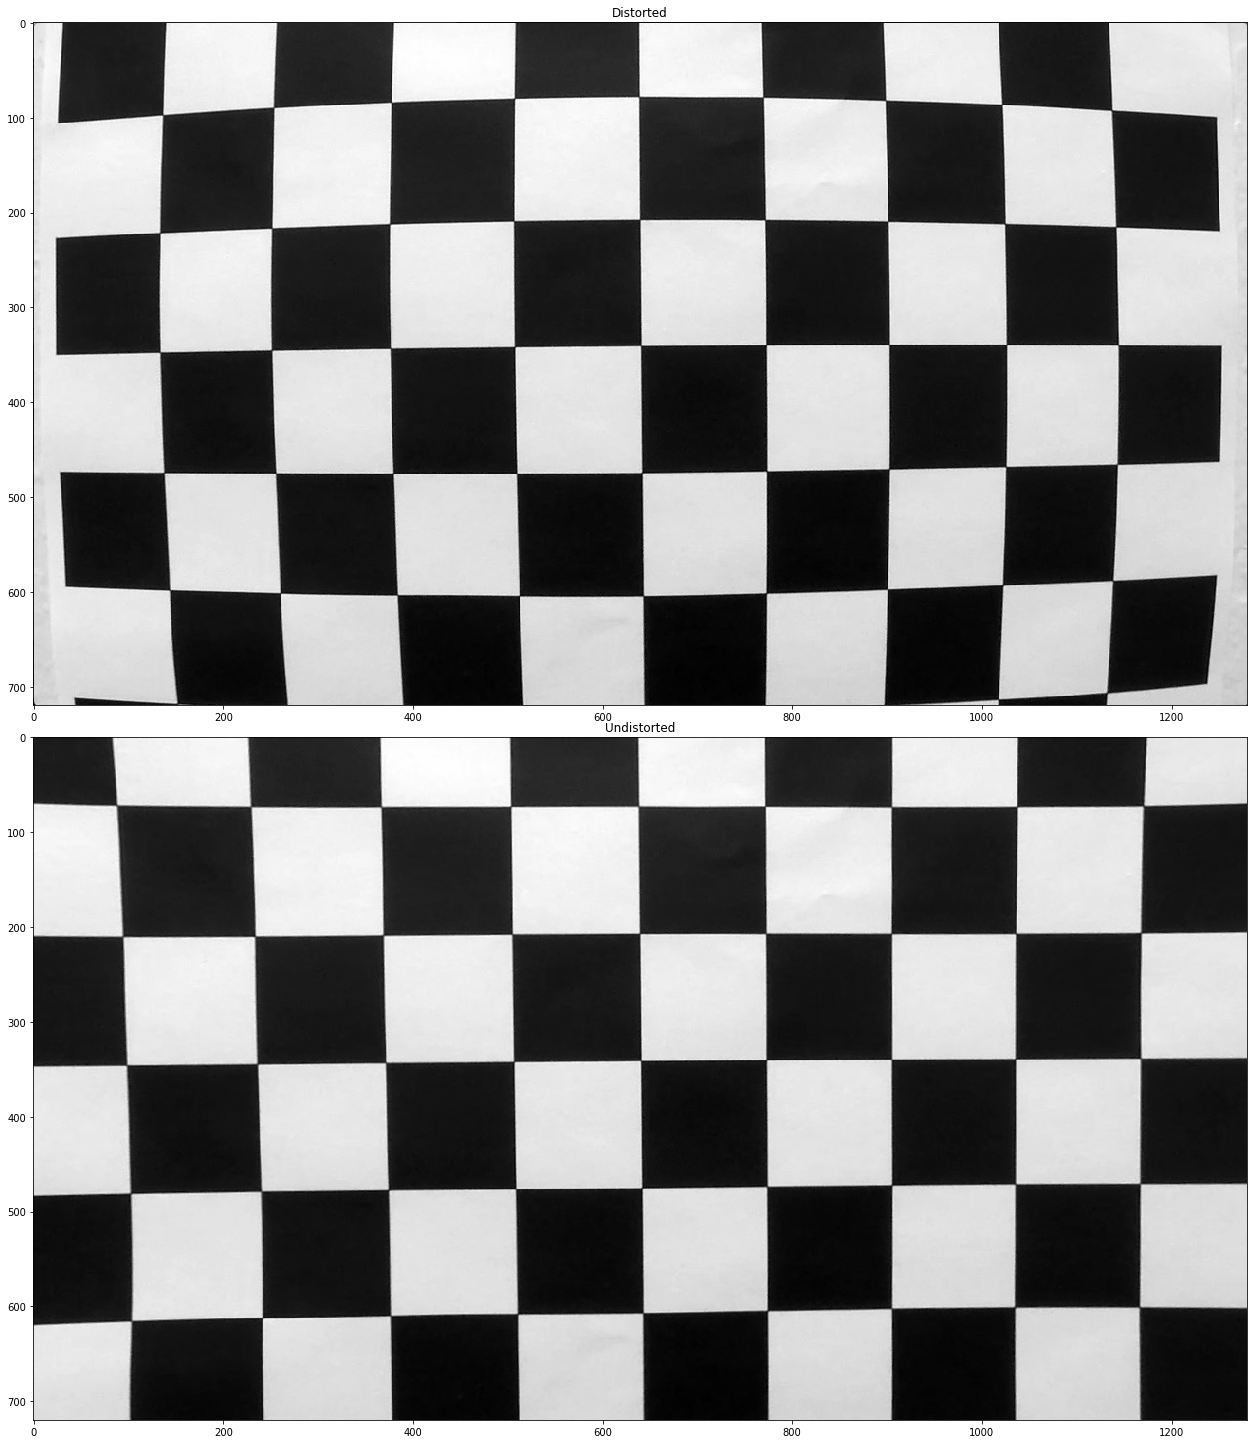

In [19]:
# Find the camera distortion from the image points discovered above
ok, camera_matrix, distortion_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    object_points,
    image_points,
    (720, 1280),
    None,
    None,
)

# Create an example image with an undistortion operation applied
example_distorted_image = cv2.imread('camera_cal/calibration1.jpg')
example_distorted_image_grayscaled = cv2.cvtColor(example_distorted_image, cv2.COLOR_BGR2GRAY)
example_undistorted_image = cv2.undistort(
    example_distorted_image_grayscaled,
    camera_matrix,
    distortion_coeffs
)

# Display our example images
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
f.tight_layout()
ax1.set_title("Distorted")
ax1.imshow(example_distorted_image_grayscaled, cmap='gray')
ax2.set_title("Undistorted")
ax2.imshow(example_undistorted_image, cmap='gray')

# II. Image Processing Pipeline

## 1. Distortion Correction

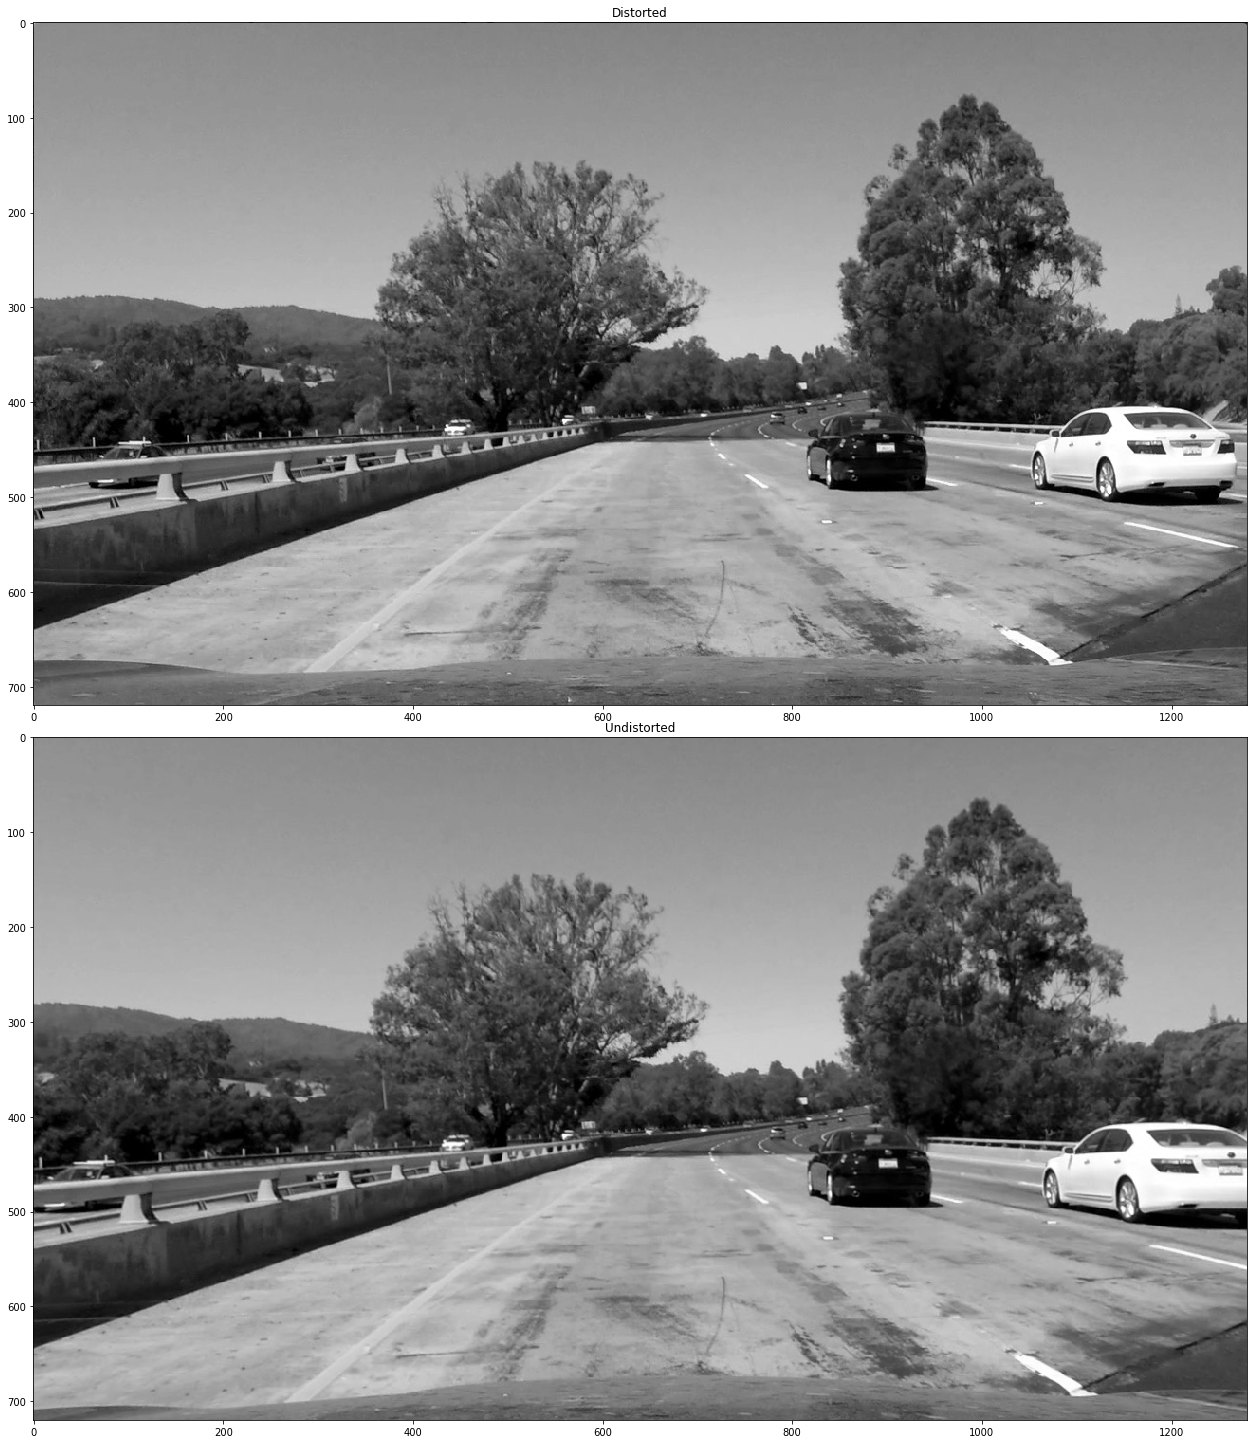

In [20]:
# Get a test image to undistort
example_distorted_test_image = cv2.imread('test_images/test1.jpg')
example_distorted_test_image_grayscaled = cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2GRAY)
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image_grayscaled,
    camera_matrix,
    distortion_coeffs
)

# Display the distorted test alongside its undistorted counterpart
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
f.tight_layout()
ax1.set_title("Distorted")
ax1.imshow(example_distorted_test_image_grayscaled, cmap='gray')
ax2.set_title("Undistorted")
ax2.imshow(example_undistorted_test_image, cmap='gray')

## 2. Color Transforms & Gradient Thresholding

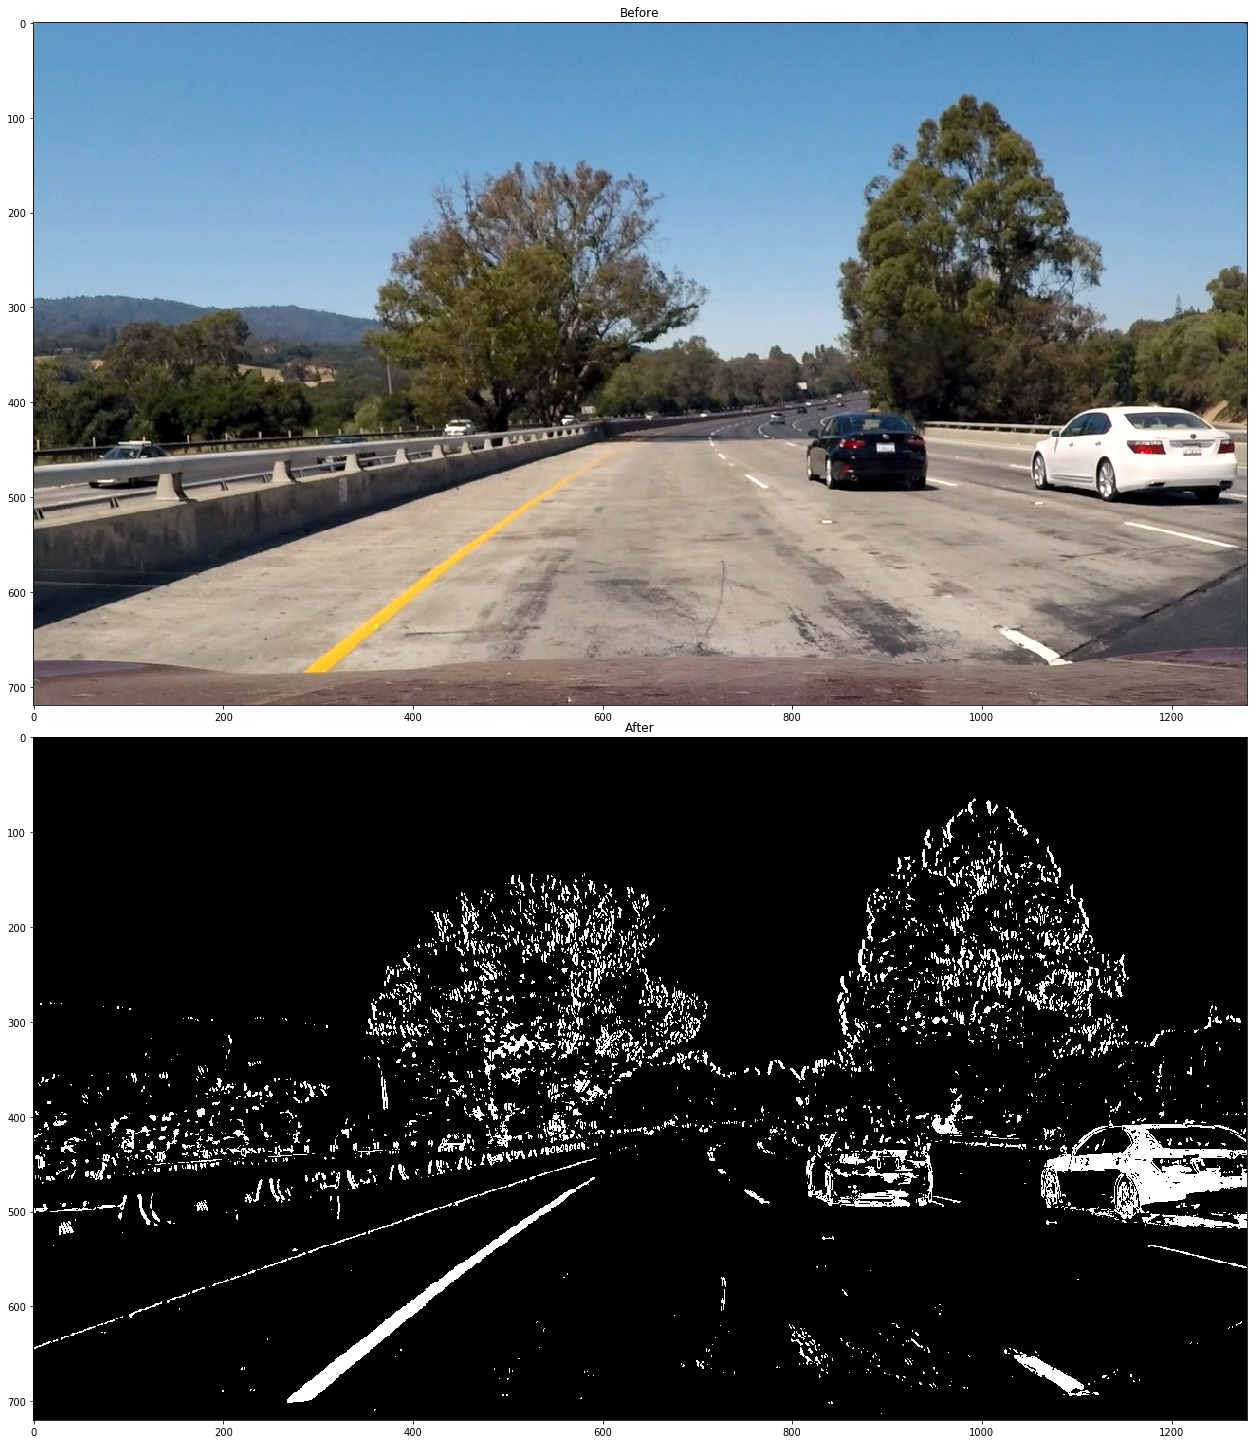

In [21]:
# We'll continue using the example from above
example_distorted_test_image = cv2.imread('test_images/test1.jpg')
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image,
    camera_matrix,
    distortion_coeffs
)

def generate_binary_image(image, sobel_thresholds=(30, 140), color_thresholds=(150, 255)):
    # Convert to HLS color space
    hls_test_image = cv2.cvtColor(
        image,
        cv2.COLOR_RGB2HLS,
    )

    # Grab the S channel for separate usage
    s_channel = hls_test_image[:,:,2]

    # Also get a grayscaled version of the image
    grayscaled_test_image = cv2.cvtColor(
        image,
        cv2.COLOR_RGB2GRAY,
    )

    # Do the Sobel filter
    sobel_x = cv2.Sobel(
        grayscaled_test_image,
        cv2.CV_64F,
        1,
        0,
    )
    absolute_sobel_x = np.absolute(sobel_x)
    scaled_sobel_x = np.uint8(255*absolute_sobel_x/np.max(absolute_sobel_x))

    # Thresholding on the x gradient
    sobel_x_binary = np.zeros_like(scaled_sobel_x)
    sobel_x_binary[(scaled_sobel_x >= sobel_thresholds[0]) & (scaled_sobel_x <= sobel_thresholds[1])] = 1

    # Thresholding on the color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresholds[0]) & (s_channel <= color_thresholds[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_x_binary)
    combined_binary[(s_binary == 1) | (sobel_x_binary == 1)] = 1
    return combined_binary

# Display the before and after
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
f.tight_layout()
ax1.set_title("Before")
ax1.imshow(cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2RGB))
ax2.set_title("After")
ax2.imshow(generate_binary_image(example_undistorted_test_image), cmap='gray')

## 3. Perspective Transform

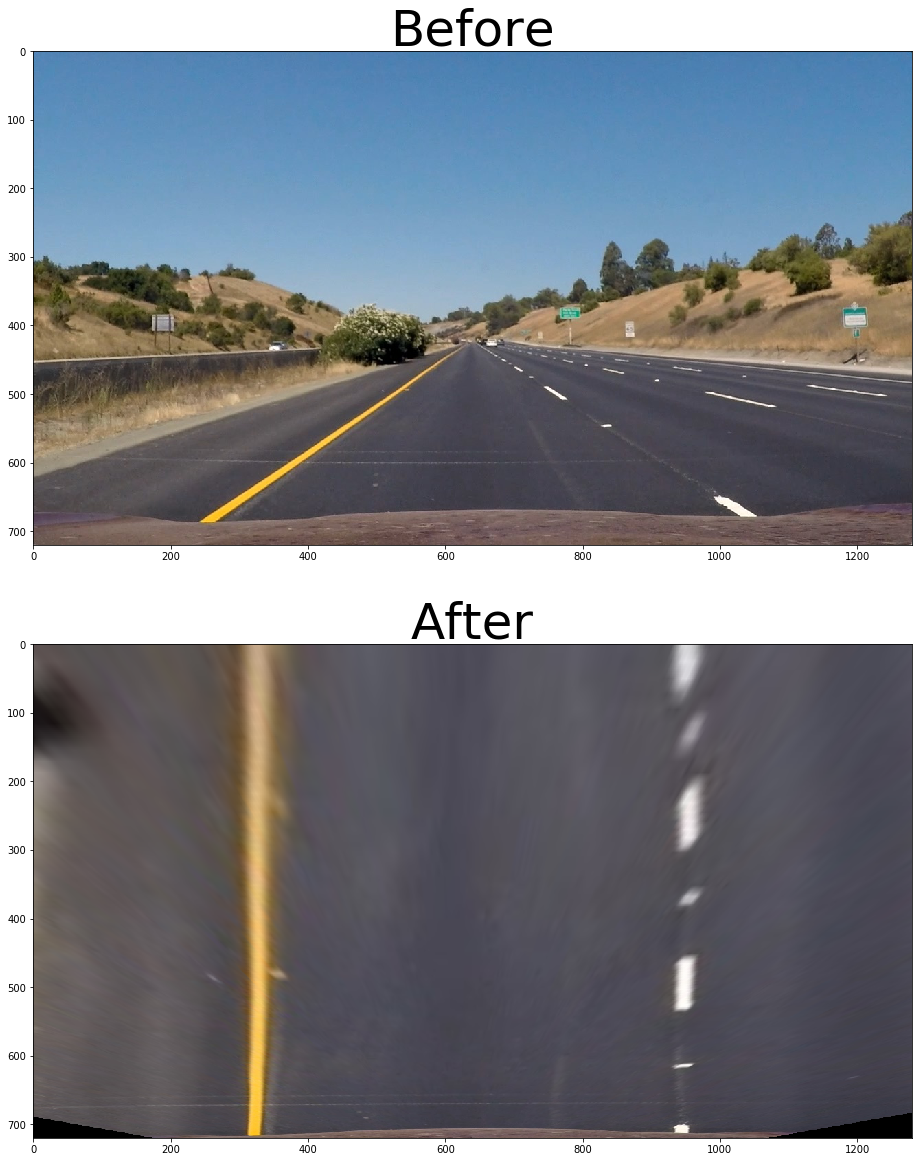

In [22]:
# We'll continue using the example from above
example_distorted_test_image = cv2.imread('test_images/straight_lines1.jpg')
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image,
    camera_matrix,
    distortion_coeffs
)

def warper(image):
    image_size = image.shape[:2]
    img_size = (image_size[1], image_size[0])
    src = np.float32(
        [[(img_size[0] / 2) - 45, img_size[1] / 2 + 90],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 45), img_size[1] / 2 + 90]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    inverse_warp_matrix = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, perspective_matrix, img_size)
    return warped, inverse_warp_matrix


# Display the before and after
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
ax1.set_title("Before", fontsize=50)
ax1.imshow(cv2.cvtColor(example_distorted_test_image, cv2.COLOR_BGR2RGB))
ax2.set_title("After", fontsize=50)
ax2.imshow(cv2.cvtColor(warper(example_undistorted_test_image)[0], cv2.COLOR_BGR2RGB))





## 4. Identify lane-line pixels and fit a polynomial

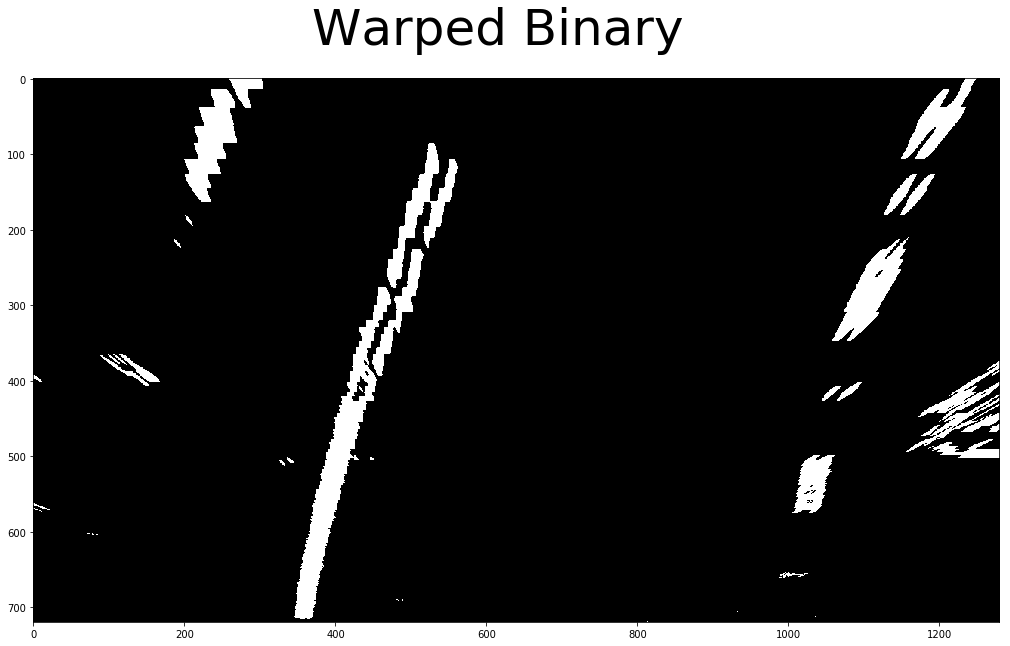

In [23]:
# We'll continue using the example from above
example_distorted_test_image = cv2.imread('test_images/test6.jpg')
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image,
    camera_matrix,
    distortion_coeffs
)

# At this step we need the binary image
binary = generate_binary_image(example_undistorted_test_image)

# Here's what that looks like warped
warped = warper(binary)[0]
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Warped Binary", fontsize=50)
plt.imshow(warped, cmap='gray')

In [24]:
def windowed_lane_search(image, left_fit, right_fit):
    output_buffer = np.dstack((image, image, image))*255
    
    # Get a histogram of the bottom half of the image
    histogram = np.sum(image[np.int(image.shape[0] / 2):, :], axis=0)
#     plt.figure()
#     plt.plot(histogram)

    # Discover some sane starting points for the left and right lanes
    midpoint = np.int(histogram.shape[0]/2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint

    num_windows = 9
    window_height = np.int(warped.shape[0]/num_windows)

    # x/y positions of all nonzeros in the image
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Position buffers for use when moving from window to window
    # Starts at our sane starting points
    current_left_x = left_x_base
    current_right_x = right_x_base

    # How much margine on each side of each window?
    margin = 100

    # Minimum number of pixels needed to recenter a window?
    recenter_minimum = 50

    # Buffers for left and right lane pixel indices
    left_lane_indices = []
    right_lane_indices = []

    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window + 1) * window_height
        win_y_high = image.shape[0] - window * window_height
        win_xleft_low = current_left_x - margin
        win_xleft_high = current_left_x + margin
        win_xright_low = current_right_x - margin
        win_xright_high = current_right_x + margin
        # Draw the windows on the visualization image
        cv2.rectangle(
            output_buffer,
            (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high),
            (0, 255, 0),
            2
        ) 
        cv2.rectangle(
            output_buffer,
            (win_xright_low, win_y_low),
            (win_xright_high, win_y_high),
            (0, 255, 0),
            2
        ) 
        # Identify the nonzero pixels in x and y within the window
        good_left_indices = (
            (nonzero_y >= win_y_low) & 
            (nonzero_y < win_y_high) & 
            (nonzero_x >= win_xleft_low) & 
            (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_indices = (
            (nonzero_y >= win_y_low) & 
            (nonzero_y < win_y_high) & 
            (nonzero_x >= win_xright_low) & 
            (nonzero_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_indices) > recenter_minimum:
            current_left_x = np.int(np.mean(nonzero_x[good_left_indices]))
        if len(good_right_indices) > recenter_minimum:        
            current_right_x = np.int(np.mean(nonzero_x[good_right_indices]))
            
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)
    
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices]
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    
    try:
        new_left_fit = np.polyfit(left_y, left_x, 2)
    except TypeError:
        new_left_fit = left_fit
    try:
        new_right_fit = np.polyfit(right_y, right_x, 2)
    except TypeError:
        new_right_fit = right_fit
    
    # Do visualization

    output_buffer[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
    output_buffer[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]
    
    return new_left_fit, new_right_fit, output_buffer

def preexisting_lane_search(image, left_fit, right_fit):
    nonzero = image.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 100
    left_lane_indices = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] - margin)) & (nonzero_x < (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin))) 
    right_lane_indices = ((nonzero_x > (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] - margin)) & (nonzero_x < (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices] 
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(left_y, left_x, 2)
        right_fit = np.polyfit(right_y, right_x, 2)
    except TypeError:
        left_fit, right_fit, _ = windowed_lane_search(image, left_fit, right_fit)
    
    return left_fit, right_fit

(720, 0)

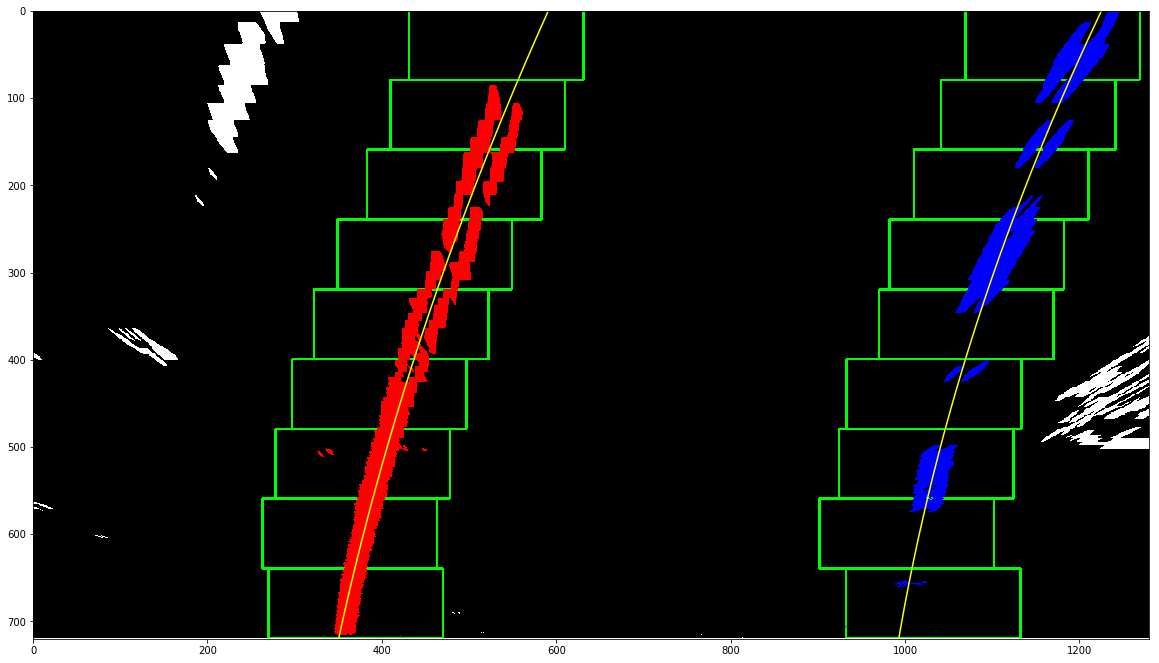

In [25]:
left_fit, right_fit, out_image = windowed_lane_search(warped, None, None)

# Generate x and y values for plotting
ploty = np.linspace(0, out_image.shape[0]-1, out_image.shape[0] )
left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.figure(figsize=(20, 20))
plt.imshow(out_image)
plt.plot(left_fit_x, ploty, color='yellow')
plt.plot(right_fit_x, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 5. Computing Radius of Curvature

In [ ]:
meters_per_pixel_y = 30/720
meters_per_pixel_x = 3.7/700

def radius_of_curvature(polynomial, y_value):
    a, b, c = polynomial
    return (1 + (((2 * a * y_value * meters_per_pixel_y) + b) ** 2) ** (3/2))/ np.absolute(2 * a)

def distance_from_center(left_fit, right_fit, y_value, x_size):
    left_fit_x = left_fit[0]*y_value**2 + left_fit[1]*y_value + left_fit[2]
    right_fit_x = right_fit[0]*y_value**2 + right_fit[1]*y_value + right_fit[2]
    
    center_of_car = x_size / 2
    center_of_lane = (left_fit_x + right_fit_x) / 2
    return (center_of_lane - center_of_car) * meters_per_pixel_x

## 6. Drawing Detected Lanes

In [ ]:
def draw_lane_lines(warped_image, left_fit, right_fit, inverse_warp_matrix, destination_image):
    # Image for drawing
    destination_image = np.copy(destination_image)
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    
    ploty = np.linspace(0, warp_zero.shape[0]-1, warp_zero.shape[0] )
    left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Convert x & y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_warp_matrix, (warp_zero.shape[1], warp_zero.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(destination_image, 1, newwarp, 0.3, 0)
    
    return result
    
def draw_radius_of_curvature(left_fit, right_fit, image):
    y_value = image.shape[1]
    radius_left = radius_of_curvature(left_fit, y_value)
    radius_right = radius_of_curvature(right_fit, y_value)
    
    min_radius = min([radius_left, radius_right])
    
    cv2.putText(
        image,
        "Radius of Curvature: {radius} m".format(radius=round(min_radius, 3)),
        (10, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.1,
        (255, 255, 255),
        2,
    )

def draw_center_offset(left_fit, right_fit, image):
    y_value = image.shape[0]
    distance = distance_from_center(left_fit, right_fit, y_value, image.shape[1])
    
    cv2.putText(
        image,
        "Offset from center of lane: {distance} m".format(distance=round(distance, 3)),
        (10, 150),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.1,
        (255, 255, 255),
        2,
    )
    

937.254861654 325.147422491 631.201142073 640.0


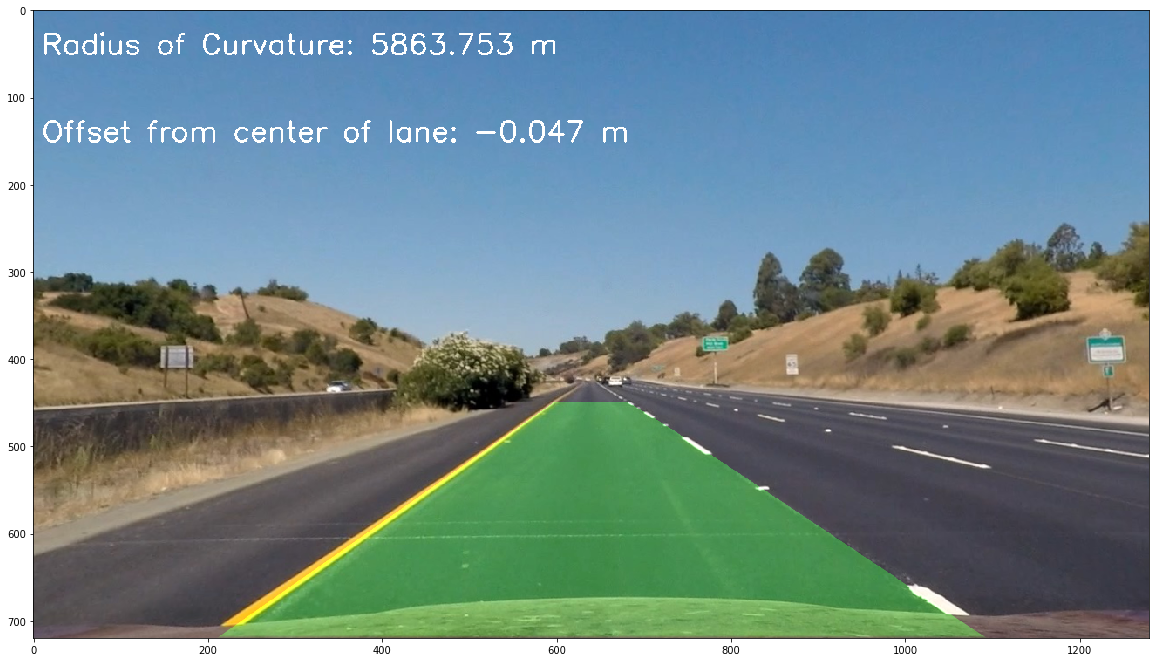

In [93]:
# We'll continue using the example from above
example_distorted_test_image = cv2.imread('test_images/straight_lines1.jpg')
example_undistorted_test_image = cv2.undistort(
    example_distorted_test_image,
    camera_matrix,
    distortion_coeffs
)
example_undistorted_test_image = cv2.cvtColor(example_undistorted_test_image, cv2.COLOR_BGR2RGB)

# At this step we need the binary image
binary = generate_binary_image(example_undistorted_test_image)

# Here's what that looks like warped
warped, inverse_warp_matrix = warper(binary)

left_fit, right_fit, _ = windowed_lane_search(warped, None, None)

new_image = draw_lane_lines(warped, left_fit, right_fit, inverse_warp_matrix, example_undistorted_test_image)
draw_radius_of_curvature(left_fit, right_fit, new_image)
draw_center_offset(left_fit, right_fit, new_image)

plt.figure(figsize=(20, 20))
plt.imshow(new_image)

# III. Pipelining for Video

In [94]:
def lane_detector_pipeline(image, left, right):
    image = np.copy(image)
    undistorted_image = cv2.undistort(
        image,
        camera_matrix,
        distortion_coeffs
    )
    binary = generate_binary_image(undistorted_image)
    warped, inverse_warp_matrix = warper(binary)
    if left == None and right == None:
        left_fit, right_fit, _ = windowed_lane_search(warped, left, right)
    else:
        left_fit, right_fit = preexisting_lane_search(warped, left, right)
    drawn = draw_lane_lines(
        warped,
        left_fit,
        right_fit,
        inverse_warp_matrix,
        undistorted_image
    )
    draw_radius_of_curvature(left_fit, right_fit, drawn)
    draw_center_offset(left_fit, right_fit, drawn)
#     plt.figure()
#     plt.imshow(drawn)
    return drawn, left_fit, right_fit


In [95]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
class ImageProcessor:
    per_image_fit_left = None
    per_image_fit_right = None
    def process_image(self, image):
        drawn, self.per_image_fit_left, self.per_image_fit_right = lane_detector_pipeline(image, self.per_image_fit_left, self.per_image_fit_right)
        return drawn

processor = ImageProcessor()
    
output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(processor.process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(output, audio=False)

937.254861654 325.283028579 631.268945116 640.0
[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


  0%|          | 1/1261 [00:00<03:29,  6.02it/s]

1023.91742282 376.878352321 700.397887571 640.0


  0%|          | 2/1261 [00:00<03:28,  6.03it/s]

1013.91122524 376.772893282 695.342059259 640.0


  0%|          | 3/1261 [00:00<03:30,  5.99it/s]

1014.01303294 377.613245699 695.813139322 640.0


  0%|          | 4/1261 [00:00<03:32,  5.91it/s]

1012.24044043 378.816846625 695.528643529 640.0


  0%|          | 5/1261 [00:00<03:29,  6.00it/s]

1009.46609721 381.983220993 695.724659103 640.0


  0%|          | 6/1261 [00:01<03:31,  5.94it/s]

1007.05188518 383.654924983 695.353405082 640.0


  1%|          | 7/1261 [00:01<03:33,  5.89it/s]

1008.27301952 385.796135244 697.034577383 640.0


  1%|          | 8/1261 [00:01<03:30,  5.95it/s]

1014.41225893 387.111212452 700.761735692 640.0


  1%|          | 10/1261 [00:01<03:38,  5.72it/s]

1017.30344385 388.658281759 702.980862803 640.0
1020.93968133 388.026636368 704.483158849 640.0


  1%|          | 12/1261 [00:02<03:26,  6.06it/s]

1022.14788682 387.352414817 704.750150819 640.0
1021.90827687 386.094919734 704.001598303 640.0


  1%|          | 14/1261 [00:02<03:17,  6.30it/s]

1022.43664971 385.763870588 704.100260149 640.0
1017.10571936 384.769704654 700.937712007 640.0


  1%|▏         | 16/1261 [00:02<03:08,  6.61it/s]

1009.83836911 383.963716417 696.901042766 640.0
999.317528067 383.422944821 691.370236444 640.0


  1%|▏         | 17/1261 [00:02<03:14,  6.38it/s]

997.754464003 382.941317083 690.347890543 640.0


  2%|▏         | 19/1261 [00:03<04:01,  5.15it/s]

996.67411312 383.709585417 690.191849269 640.0
995.416772617 381.427574692 688.422173654 640.0


  2%|▏         | 21/1261 [00:03<03:25,  6.04it/s]

990.877865985 379.443482755 685.16067437 640.0
985.503798634 378.803349628 682.153574131 640.0


  2%|▏         | 23/1261 [00:03<03:16,  6.31it/s]

987.604019633 375.959910983 681.781965308 640.0
993.995247808 372.747923097 683.371585453 640.0


  2%|▏         | 25/1261 [00:04<03:33,  5.79it/s]

1003.89204862 371.684277196 687.788162909 640.0
1006.46625834 368.870927306 687.668592825 640.0


  2%|▏         | 27/1261 [00:04<03:32,  5.81it/s]

1010.63578583 366.641438502 688.638612165 640.0
1010.26593742 363.041080634 686.653509026 640.0


  2%|▏         | 28/1261 [00:04<03:37,  5.68it/s]

1010.86307609 361.839845929 686.351461009 640.0


  2%|▏         | 29/1261 [00:05<03:56,  5.22it/s]

1005.34228828 361.23375463 683.288021453 640.0


  2%|▏         | 30/1261 [00:05<04:51,  4.22it/s]

1004.03113417 360.959509416 682.495321794 640.0


  2%|▏         | 31/1261 [00:05<04:50,  4.23it/s]

998.440243529 361.396871418 679.918557474 640.0


  3%|▎         | 33/1261 [00:06<04:34,  4.48it/s]

993.261601607 361.448687921 677.355144764 640.0
987.556894789 360.830424565 674.193659677 640.0


  3%|▎         | 35/1261 [00:06<03:53,  5.25it/s]

996.085102411 361.322743345 678.703922878 640.0
1010.43070015 363.046027497 686.738363825 640.0


  3%|▎         | 37/1261 [00:06<03:23,  6.02it/s]

1001.95419084 365.239980872 683.597085857 640.0
998.122216314 366.716015584 682.419115949 640.0


  3%|▎         | 39/1261 [00:06<03:17,  6.19it/s]

1001.60924757 368.637790863 685.123519216 640.0
992.420291439 370.469906058 681.445098749 640.0


  3%|▎         | 41/1261 [00:07<03:07,  6.51it/s]

994.472543606 372.079496361 683.276019983 640.0
991.191464196 373.057550799 682.124507498 640.0


  3%|▎         | 43/1261 [00:07<03:03,  6.63it/s]

993.898475318 375.227462877 684.562969097 640.0
997.51088206 378.73697367 688.123927865 640.0


  4%|▎         | 45/1261 [00:07<02:59,  6.79it/s]

996.365728061 379.049507944 687.707618002 640.0
996.579790253 379.882514066 688.231152159 640.0


  4%|▎         | 47/1261 [00:08<03:09,  6.41it/s]

992.867299833 380.591717609 686.729508721 640.0
1004.13153811 380.226790919 692.179164515 640.0


  4%|▍         | 49/1261 [00:08<03:02,  6.64it/s]

1008.96800757 380.226326966 694.59716727 640.0
1012.49706847 379.297840994 695.897454734 640.0


  4%|▍         | 51/1261 [00:08<02:56,  6.87it/s]

1013.46214405 380.457324241 696.959734147 640.0
1009.05618088 380.576890175 694.816535528 640.0


  4%|▍         | 53/1261 [00:09<02:55,  6.90it/s]

1007.11781335 379.843317412 693.48056538 640.0
1002.67247651 379.544146268 691.108311389 640.0


  4%|▍         | 55/1261 [00:09<02:58,  6.76it/s]

996.712538651 378.426197296 687.569367974 640.0
998.755979944 377.42282192 688.089400932 640.0


  5%|▍         | 57/1261 [00:09<03:19,  6.03it/s]

998.881841127 375.671337936 687.276589531 640.0
1000.85539142 374.41668637 687.636038896 640.0


  5%|▍         | 59/1261 [00:10<03:21,  5.97it/s]

1003.21259043 373.521860891 688.367225663 640.0
1012.76775699 372.778861874 692.773309433 640.0


  5%|▍         | 61/1261 [00:10<03:10,  6.30it/s]

1005.72885603 372.043966976 688.886411503 640.0
993.359193077 371.229191814 682.294192445 640.0


  5%|▍         | 63/1261 [00:10<03:01,  6.59it/s]

980.11215706 370.612416647 675.362286854 640.0
978.141065132 369.449921804 673.795493468 640.0


  5%|▌         | 65/1261 [00:10<02:59,  6.66it/s]

982.06082725 369.166033034 675.613430142 640.0
981.778921143 367.593400202 674.686160673 640.0


  5%|▌         | 67/1261 [00:11<02:56,  6.77it/s]

984.654629282 365.872385484 675.263507383 640.0
985.449992805 365.358692196 675.404342501 640.0


  5%|▌         | 69/1261 [00:11<03:05,  6.44it/s]

984.595253253 364.313619161 674.454436207 640.0
984.45546892 364.448015812 674.451742366 640.0


  6%|▌         | 71/1261 [00:11<03:01,  6.56it/s]

982.832025868 363.474087903 673.153056886 640.0
978.16031301 363.380895051 670.770604031 640.0


  6%|▌         | 73/1261 [00:12<02:59,  6.63it/s]

976.571000758 362.461624321 669.516312539 640.0
979.139000874 361.369923639 670.254462257 640.0


  6%|▌         | 75/1261 [00:12<03:00,  6.58it/s]

977.897488198 360.400752257 669.149120227 640.0
977.759090676 359.999039162 668.879064919 640.0


  6%|▌         | 77/1261 [00:12<02:53,  6.84it/s]

976.34244094 358.641124931 667.491782935 640.0
983.010908263 356.471853671 669.741380967 640.0


  6%|▋         | 79/1261 [00:12<02:46,  7.11it/s]

981.045442239 354.988433512 668.016937875 640.0
980.519433556 352.537200533 666.528317045 640.0


  6%|▋         | 81/1261 [00:13<02:41,  7.33it/s]

976.039725343 349.542629901 662.791177622 640.0
973.998361414 347.942281448 660.970321431 640.0


  7%|▋         | 83/1261 [00:13<02:38,  7.44it/s]

973.155647977 344.971136513 659.063392245 640.0
975.639217485 343.118181261 659.378699373 640.0


  7%|▋         | 85/1261 [00:13<02:35,  7.54it/s]

968.927205759 340.103481418 654.515343588 640.0
979.286234666 338.213991296 658.750112981 640.0


  7%|▋         | 87/1261 [00:14<02:36,  7.51it/s]

983.775400061 336.647959642 660.211679851 640.0
987.996272763 336.579890063 662.288081413 640.0


  7%|▋         | 89/1261 [00:14<02:39,  7.34it/s]

980.569119999 337.115719127 658.842419563 640.0
977.424542533 337.157907525 657.291225029 640.0


  7%|▋         | 91/1261 [00:14<02:35,  7.54it/s]

967.93281215 339.228180464 653.580496307 640.0
971.571047731 339.443353696 655.507200713 640.0


  7%|▋         | 93/1261 [00:14<02:33,  7.63it/s]

972.780339521 341.139836038 656.960087779 640.0
973.201513793 342.932617432 658.067065613 640.0


  8%|▊         | 95/1261 [00:15<02:28,  7.87it/s]

974.107950261 343.924741243 659.016345752 640.0
972.695514411 344.85645735 658.775985881 640.0


  8%|▊         | 97/1261 [00:15<02:26,  7.93it/s]

973.515835752 345.331671558 659.423753655 640.0
970.870912269 346.496208867 658.683560568 640.0


  8%|▊         | 99/1261 [00:15<02:28,  7.80it/s]

974.398596993 346.844949657 660.621773325 640.0
972.606813068 348.018873705 660.312843386 640.0


  8%|▊         | 101/1261 [00:15<02:32,  7.62it/s]

971.087642846 348.067469447 659.577556147 640.0
971.2045259 348.533255296 659.868890598 640.0


  8%|▊         | 103/1261 [00:16<02:32,  7.60it/s]

965.391463781 348.556953417 656.974208599 640.0
967.315719672 349.905457276 658.610588474 640.0


  8%|▊         | 105/1261 [00:16<02:32,  7.56it/s]

964.957377301 351.331960375 658.144668838 640.0
969.17002975 351.60528894 660.387659345 640.0


  8%|▊         | 107/1261 [00:16<02:38,  7.29it/s]

972.744741276 352.105949375 662.425345326 640.0
971.185166073 352.690980962 661.938073518 640.0


  9%|▊         | 109/1261 [00:16<02:43,  7.03it/s]

966.868551171 354.189363238 660.528957204 640.0
967.831577119 354.184513182 661.008045151 640.0


  9%|▉         | 111/1261 [00:17<02:46,  6.89it/s]

978.061239662 354.181615308 666.121427485 640.0
982.638263587 355.372812681 669.005538134 640.0


  9%|▉         | 113/1261 [00:17<02:43,  7.01it/s]

986.623687549 354.743022541 670.683355045 640.0
983.11077505 355.907943172 669.509359111 640.0


  9%|▉         | 115/1261 [00:17<02:45,  6.93it/s]

984.954340056 356.74064372 670.847491888 640.0
984.57504097 358.32931722 671.452179095 640.0


  9%|▉         | 117/1261 [00:18<02:49,  6.75it/s]

979.31732372 359.408333747 669.362828734 640.0
980.589980155 359.66372946 670.126854807 640.0


  9%|▉         | 119/1261 [00:18<02:48,  6.78it/s]

984.065842912 361.76593162 672.915887266 640.0
985.926684768 362.419607455 674.173146111 640.0


 10%|▉         | 121/1261 [00:18<02:48,  6.76it/s]

991.374167789 364.588496517 677.981332153 640.0
995.778045125 366.145134092 680.961589608 640.0


 10%|▉         | 123/1261 [00:19<02:55,  6.49it/s]

993.868267382 367.42815702 680.648212201 640.0
994.081361046 369.347186266 681.714273656 640.0


 10%|▉         | 125/1261 [00:19<02:54,  6.50it/s]

995.178934863 369.883360938 682.531147901 640.0
990.704598227 371.286649605 680.995623916 640.0


 10%|█         | 127/1261 [00:19<02:49,  6.70it/s]

992.568201446 372.434774496 682.501487971 640.0
990.619982899 373.837877108 682.228930004 640.0


 10%|█         | 128/1261 [00:19<02:48,  6.73it/s]

992.437712296 374.58319039 683.510451343 640.0


 10%|█         | 129/1261 [00:20<03:09,  5.96it/s]

994.230026423 376.759083373 685.494554898 640.0


 10%|█         | 130/1261 [00:20<03:37,  5.19it/s]

993.507339263 376.54490521 685.026122237 640.0


 10%|█         | 132/1261 [00:20<03:51,  4.88it/s]

995.839010084 378.107005603 686.973007844 640.0
997.15512846 379.627939301 688.39153388 640.0


 11%|█         | 134/1261 [00:21<03:26,  5.46it/s]

1003.10761293 381.227334238 692.167473585 640.0
1007.24567889 382.706215248 694.975947068 640.0


 11%|█         | 136/1261 [00:21<03:12,  5.86it/s]

1006.65364724 383.109053796 694.881350518 640.0
1005.22317938 384.248233991 694.735706688 640.0


 11%|█         | 138/1261 [00:21<03:03,  6.13it/s]

1005.20392231 383.530351936 694.36713712 640.0
1006.34834057 382.254291255 694.30131591 640.0


 11%|█         | 140/1261 [00:21<02:52,  6.51it/s]

1009.70357781 380.690945372 695.197261589 640.0
1008.53058858 379.409158677 693.969873626 640.0


 11%|█▏        | 142/1261 [00:22<02:52,  6.50it/s]

1007.18959679 378.474419479 692.832008135 640.0
1001.67397458 377.81486237 689.744418474 640.0


 11%|█▏        | 144/1261 [00:22<02:51,  6.53it/s]

998.658991198 377.947594559 688.303292879 640.0
999.390859964 377.169785675 688.28032282 640.0


 12%|█▏        | 146/1261 [00:22<02:49,  6.58it/s]

999.775262453 375.60677773 687.691020091 640.0
1003.2513819 374.587068193 688.919225048 640.0


 12%|█▏        | 148/1261 [00:23<02:50,  6.53it/s]

1005.01452597 375.026754986 690.020640479 640.0
1003.02404743 375.690941884 689.357494657 640.0


 12%|█▏        | 150/1261 [00:23<02:48,  6.61it/s]

1000.4583877 375.320070025 687.889228863 640.0
1000.09579603 375.042118427 687.568957229 640.0


 12%|█▏        | 152/1261 [00:23<02:45,  6.68it/s]

998.37753368 374.7792765 686.57840509 640.0
997.131051814 372.125498193 684.628275004 640.0


 12%|█▏        | 154/1261 [00:24<02:44,  6.72it/s]

992.170452326 371.611290521 681.890871424 640.0
992.287108339 371.957650683 682.122379511 640.0


 12%|█▏        | 156/1261 [00:24<02:45,  6.67it/s]

994.899142024 370.67135178 682.785246902 640.0
994.406153887 369.634041372 682.02009763 640.0


 13%|█▎        | 158/1261 [00:24<02:51,  6.43it/s]

994.476761074 368.397766765 681.43726392 640.0
996.00812211 367.085825867 681.546973989 640.0


 13%|█▎        | 160/1261 [00:24<02:46,  6.60it/s]

1002.99410144 366.112155102 684.55312827 640.0
995.189376304 364.461470571 679.825423438 640.0


 13%|█▎        | 162/1261 [00:25<02:44,  6.69it/s]

994.966734795 365.09115746 680.028946127 640.0
992.486385428 362.955349959 677.720867694 640.0


 13%|█▎        | 164/1261 [00:25<02:45,  6.61it/s]

995.67551951 362.892592329 679.28405592 640.0
988.978724186 363.006424118 675.992574152 640.0


 13%|█▎        | 166/1261 [00:25<02:44,  6.67it/s]

978.242655359 361.777546572 670.010100965 640.0
981.088302815 361.593480862 671.340891839 640.0


 13%|█▎        | 168/1261 [00:26<02:44,  6.64it/s]

985.234207347 360.851224474 673.042715911 640.0
984.858892946 361.504834645 673.181863796 640.0


 13%|█▎        | 170/1261 [00:26<02:48,  6.46it/s]

985.452963729 361.028413184 673.240688456 640.0
979.6932801 358.799921752 669.246600926 640.0


 14%|█▎        | 172/1261 [00:26<02:46,  6.54it/s]

965.456122434 358.221481197 661.838801816 640.0
973.953334554 356.398693755 665.176014155 640.0


 14%|█▍        | 174/1261 [00:27<02:43,  6.64it/s]

971.237453244 353.815571777 662.52651251 640.0
970.021650163 352.169259694 661.095454929 640.0


 14%|█▍        | 176/1261 [00:27<02:39,  6.79it/s]

969.320358446 350.790215941 660.055287193 640.0
970.032016915 349.050620693 659.541318804 640.0


 14%|█▍        | 178/1261 [00:27<02:50,  6.35it/s]

972.485529308 349.022649201 660.754089254 640.0
980.475644247 348.268770144 664.372207196 640.0


 14%|█▍        | 180/1261 [00:28<02:49,  6.37it/s]

982.185444369 347.889669418 665.037556893 640.0
987.965405191 346.822846286 667.394125739 640.0


 14%|█▍        | 182/1261 [00:28<02:42,  6.65it/s]

990.597615709 345.959884843 668.278750276 640.0
995.535068147 344.305604173 669.92033616 640.0


 15%|█▍        | 184/1261 [00:28<02:37,  6.84it/s]

1007.26224118 344.173919175 675.718080177 640.0
1005.9882078 344.541753053 675.264980428 640.0


 15%|█▍        | 186/1261 [00:28<02:33,  6.99it/s]

1002.737973 344.484625968 673.611299483 640.0
994.469103877 345.395770947 669.932437412 640.0


 15%|█▍        | 188/1261 [00:29<02:34,  6.94it/s]

995.412372605 346.687761079 671.050066842 640.0
993.264217482 350.075383938 671.66980071 640.0


 15%|█▌        | 190/1261 [00:29<02:35,  6.87it/s]

992.242478792 351.561543674 671.902011233 640.0
993.466016715 354.419313225 673.94266497 640.0


 15%|█▌        | 192/1261 [00:29<02:34,  6.91it/s]

991.914871754 357.188234565 674.55155316 640.0
991.726115749 359.858260727 675.792188238 640.0


 15%|█▌        | 194/1261 [00:30<02:37,  6.76it/s]

989.291568931 363.034585064 676.163076998 640.0
986.681493604 364.302579204 675.492036404 640.0


 16%|█▌        | 196/1261 [00:30<02:42,  6.55it/s]

983.201326499 365.109402955 674.155364727 640.0
995.316952251 365.805180709 680.56106648 640.0


 16%|█▌        | 197/1261 [00:30<03:07,  5.66it/s]

1000.73051573 365.023004737 682.876760234 640.0


 16%|█▌        | 198/1261 [00:30<03:33,  4.99it/s]

997.438407698 362.580365837 680.009386768 640.0


 16%|█▌        | 199/1261 [00:31<03:42,  4.77it/s]

994.059593876 360.697955781 677.378774829 640.0
1002.18160001

 16%|█▌        | 202/1261 [00:31<03:25,  5.15it/s]

 359.605799496 680.893699755 640.0
1004.42343625 357.228226813 680.82583153 640.0
1000.73635696 356.059015277 678.397686117 640.0


 16%|█▌        | 204/1261 [00:32<03:21,  5.23it/s]

997.690950304 354.357761134 676.024355719 640.0
998.460439793 352.827986363 675.644213078 640.0


 16%|█▋        | 205/1261 [00:32<03:15,  5.41it/s]

992.712974424 353.30317694 673.008075682 640.0


 16%|█▋        | 206/1261 [00:32<03:22,  5.21it/s]

992.744125927 353.879932429 673.312029178 640.0


 16%|█▋        | 208/1261 [00:32<03:25,  5.12it/s]

1000.9151912 354.584499921 677.749845559 640.0
1009.20525759 354.987580429 682.096419009 640.0


 17%|█▋        | 210/1261 [00:33<03:18,  5.29it/s]

1008.46310239 355.805295682 682.134199037 640.0
1004.656257 355.763966862 680.21011193 640.0


 17%|█▋        | 212/1261 [00:33<03:00,  5.80it/s]

1007.1051842 355.077094207 681.091139201 640.0
1006.63661555 355.277796066 680.957205809 640.0


 17%|█▋        | 214/1261 [00:33<03:00,  5.79it/s]

1005.76931747 354.824881518 680.297099492 640.0
1004.18056604 355.136676066 679.658621051 640.0


 17%|█▋        | 216/1261 [00:34<02:50,  6.14it/s]

997.350615834 355.02158322 676.186099527 640.0
987.842660506 355.176818532 671.509739519 640.0


 17%|█▋        | 218/1261 [00:34<02:42,  6.41it/s]

985.548286869 356.634558186 671.091422527 640.0
983.999788472 355.184402018 669.592095245 640.0


 17%|█▋        | 220/1261 [00:34<02:38,  6.56it/s]

985.949985755 356.273799608 671.111892682 640.0
982.63376159 355.825436073 669.229598831 640.0


 18%|█▊        | 222/1261 [00:35<02:37,  6.59it/s]

987.983591354 356.544077094 672.263834224 640.0
988.778647244 356.319639884 672.549143564 640.0


 18%|█▊        | 224/1261 [00:35<02:53,  5.96it/s]

986.182906544 356.279828677 671.23136761 640.0
981.45656542 356.418170407 668.937367913 640.0


 18%|█▊        | 226/1261 [00:35<02:46,  6.23it/s]

983.9248842 355.400227575 669.662555888 640.0
966.944741581 354.16270561 660.553723595 640.0


 18%|█▊        | 228/1261 [00:36<02:55,  5.88it/s]

968.92331537 353.528087654 661.225701512 640.0
969.156493489 351.747588874 660.452041182 640.0


 18%|█▊        | 230/1261 [00:36<02:47,  6.15it/s]

968.469728246 351.144450081 659.807089164 640.0
966.963430381 349.653108711 658.308269546 640.0


 18%|█▊        | 232/1261 [00:36<02:46,  6.19it/s]

965.522409763 348.34667746 656.934543612 640.0
959.143676371 345.60485278 652.374264576 640.0


 19%|█▊        | 234/1261 [00:37<02:47,  6.12it/s]

956.76076555 343.254922593 650.007844072 640.0
963.017859788 341.442286207 652.230072997 640.0


 19%|█▊        | 236/1261 [00:37<02:45,  6.20it/s]

963.133061451 338.560448821 650.846755136 640.0
962.230151675 337.507510947 649.868831311 640.0


 19%|█▉        | 238/1261 [00:37<02:44,  6.20it/s]

953.4562483 336.206056606 644.831152453 640.0
954.583882989 334.550739668 644.567311328 640.0


 19%|█▉        | 240/1261 [00:38<03:01,  5.62it/s]

958.508849022 332.840009684 645.674429353 640.0
959.644322271 332.530905722 646.087613996 640.0


 19%|█▉        | 242/1261 [00:38<02:44,  6.20it/s]

963.056603255 332.839646898 647.948125076 640.0
963.126248964 330.579660766 646.852954865 640.0


 19%|█▉        | 244/1261 [00:38<02:37,  6.46it/s]

963.29827609 330.317347728 646.807811909 640.0
965.180021774 330.669252527 647.924637151 640.0


 20%|█▉        | 246/1261 [00:39<02:41,  6.29it/s]

956.219645016 328.677055084 642.44835005 640.0
944.279412378 327.427741117 635.853576747 640.0


 20%|█▉        | 248/1261 [00:39<02:43,  6.18it/s]

948.616448114 326.770524169 637.693486141 640.0
949.265385806 327.889302397 638.577344102 640.0


 20%|█▉        | 250/1261 [00:39<02:39,  6.35it/s]

951.863067862 328.132014504 639.997541183 640.0
955.78428816 327.472296053 641.628292107 640.0


 20%|█▉        | 251/1261 [00:39<02:50,  5.94it/s]

954.748197702 327.260026669 641.004112186 640.0


 20%|█▉        | 252/1261 [00:40<03:39,  4.59it/s]

957.646552168 327.748178493 642.69736533 640.0


 20%|██        | 253/1261 [00:40<03:59,  4.21it/s]

958.907764206 327.597602281 643.252683244 640.0


 20%|██        | 255/1261 [00:40<03:46,  4.44it/s]

959.912084805 327.783304504 643.847694655 640.0
963.066901381 327.385344785 645.226123083 640.0


 20%|██        | 256/1261 [00:41<03:38,  4.61it/s]

959.921881583 327.584358291 643.753119937 640.0


 20%|██        | 257/1261 [00:41<03:39,  4.57it/s]

957.771178575 326.932871953 642.352025264 640.0


 21%|██        | 259/1261 [00:41<03:31,  4.74it/s]

954.107206072 327.079110633 640.593158352 640.0
954.064767573 327.021532334 640.543149953 640.0


 21%|██        | 261/1261 [00:42<03:05,  5.39it/s]

950.306577751 328.411382008 639.358979879 640.0
955.634425968 329.308851265 642.471638616 640.0


 21%|██        | 263/1261 [00:42<02:57,  5.63it/s]

951.619054922 329.349079572 640.484067247 640.0
956.00254797 330.141778144 643.072163057 640.0


 21%|██        | 265/1261 [00:42<02:54,  5.72it/s]

959.625412624 329.511497518 644.568455071 640.0
962.77390841 329.857231601 646.315570005 640.0


 21%|██        | 267/1261 [00:43<02:48,  5.91it/s]

964.912755707 329.346689891 647.129722799 640.0
968.256641747 329.725445542 648.991043644 640.0


 21%|██▏       | 269/1261 [00:43<02:47,  5.92it/s]

969.741478023 329.199655797 649.47056691 640.0
973.782687532 329.116873847 651.44978069 640.0


 21%|██▏       | 271/1261 [00:43<02:58,  5.56it/s]

984.556999976 328.529627498 656.543313737 640.0
979.988217931 329.368727294 654.678472612 640.0


 22%|██▏       | 273/1261 [00:44<02:49,  5.81it/s]

972.355407967 332.97544564 652.665426803 640.0
967.461186159 333.534245285 650.497715722 640.0


 22%|██▏       | 275/1261 [00:44<02:56,  5.60it/s]

968.649658664 336.05073614 652.350197402 640.0
970.107672536 336.526371289 653.317021912 640.0


 22%|██▏       | 277/1261 [00:44<02:56,  5.59it/s]

973.166307095 337.246646569 655.206476832 640.0
973.00757091 338.632474448 655.820022679 640.0


 22%|██▏       | 278/1261 [00:45<03:20,  4.90it/s]

974.13195399 338.955389053 656.543671522 640.0


 22%|██▏       | 279/1261 [00:45<03:26,  4.75it/s]

975.859219743 341.218027946 658.538623844 640.0
977.999423234

 22%|██▏       | 282/1261 [00:45<02:52,  5.66it/s]

 341.110230477 659.554826855 640.0
981.3416864 342.609104811 661.975395605 640.0
980.128131154 343.740400452 661.934265803 640.0


 23%|██▎       | 284/1261 [00:46<02:40,  6.10it/s]

982.020238186 344.213026618 663.116632402 640.0
975.009192041 345.177914269 660.093553155 640.0


 23%|██▎       | 286/1261 [00:46<02:37,  6.17it/s]

980.099209291 346.055419396 663.077314343 640.0
981.453858875 345.65342702 663.553642947 640.0


 23%|██▎       | 288/1261 [00:46<02:30,  6.45it/s]

977.09161254 345.515226112 661.303419326 640.0
982.618890172 346.750827537 664.684858854 640.0


 23%|██▎       | 290/1261 [00:47<02:29,  6.49it/s]

980.818195341 349.218602216 665.018398778 640.0
983.057964688 349.787967027 666.422965857 640.0


 23%|██▎       | 292/1261 [00:47<02:26,  6.61it/s]

986.913052606 351.696249492 669.304651049 640.0
988.239122191 352.493856373 670.366489282 640.0


 23%|██▎       | 293/1261 [00:47<02:28,  6.53it/s]

992.001520091 352.382864551 672.192192321 640.0


 23%|██▎       | 295/1261 [00:48<03:03,  5.26it/s]

991.796084432 353.504527944 672.650306188 640.0
989.919238944 353.773857747 671.846548345 640.0


 24%|██▎       | 297/1261 [00:48<02:48,  5.73it/s]

989.830163238 355.01045326 672.420308249 640.0
989.676048202 355.230411789 672.453229995 640.0


 24%|██▎       | 298/1261 [00:48<02:48,  5.70it/s]

987.889722954 354.188097365 671.038910159 640.0
986.254248525

 24%|██▍       | 301/1261 [00:49<02:59,  5.34it/s]

 354.779543757 670.516896141 640.0
990.056612429 353.473685668 671.765149049 640.0
989.383699422 355.049272695 672.216486059 640.0


 24%|██▍       | 303/1261 [00:49<02:57,  5.39it/s]

989.749247535 353.538659674 671.643953604 640.0
992.708259038 353.234526996 672.971393017 640.0


 24%|██▍       | 304/1261 [00:49<03:07,  5.10it/s]

996.842014696 353.827988486 675.335001591 640.0


 24%|██▍       | 305/1261 [00:50<03:43,  4.28it/s]

1009.95910871 353.526885088 681.742996899 640.0


 24%|██▍       | 306/1261 [00:50<03:58,  4.01it/s]

1008.09849532 355.390225742 681.744360531 640.0


 24%|██▍       | 307/1261 [00:50<03:51,  4.12it/s]

1006.22509352 354.915161193 680.570127354 640.0


 24%|██▍       | 308/1261 [00:50<04:05,  3.89it/s]

994.4565029 358.099178429 676.277840664 640.0


 25%|██▍       | 309/1261 [00:51<04:11,  3.79it/s]

992.328266187 357.475172318 674.901719252 640.0


 25%|██▍       | 310/1261 [00:51<05:01,  3.15it/s]

989.215787422 358.446829303 673.831308362 640.0


 25%|██▍       | 311/1261 [00:51<04:42,  3.36it/s]

989.046308148 361.019575961 675.032942054 640.0


 25%|██▍       | 312/1261 [00:52<04:51,  3.25it/s]

989.693942749 360.470439759 675.082191254 640.0


 25%|██▍       | 313/1261 [00:52<05:14,  3.01it/s]

987.768879781 362.566831054 675.167855417 640.0


 25%|██▍       | 314/1261 [00:53<05:33,  2.84it/s]

987.42869217 363.14783427 675.28826322 640.0


 25%|██▍       | 315/1261 [00:53<06:06,  2.58it/s]

984.607559825 363.779053427 674.193306626 640.0


 25%|██▌       | 316/1261 [00:53<05:29,  2.87it/s]

985.78469413 362.598908551 674.19180134 640.0


 25%|██▌       | 317/1261 [00:54<05:43,  2.75it/s]

981.365359098 362.850767572 672.108063335 640.0


 25%|██▌       | 318/1261 [00:54<05:43,  2.74it/s]

970.348792496 363.111128979 666.729960738 640.0


 25%|██▌       | 319/1261 [00:54<05:34,  2.82it/s]

973.38687708 363.123220953 668.255049017 640.0


 25%|██▌       | 320/1261 [00:55<05:11,  3.02it/s]

975.89567832 363.403592191 669.649635255 640.0


 25%|██▌       | 321/1261 [00:55<04:40,  3.35it/s]

978.570922523 363.620982358 671.095952441 640.0


 26%|██▌       | 322/1261 [00:55<04:19,  3.62it/s]

981.46109487 363.351742711 672.40641879 640.0


 26%|██▌       | 324/1261 [00:55<03:44,  4.18it/s]

984.256838272 363.984540347 674.120689309 640.0
983.124093494 362.019562666 672.57182808 640.0


 26%|██▌       | 326/1261 [00:56<03:16,  4.75it/s]

985.177937421 363.480400192 674.329168806 640.0
987.510281111 362.784070043 675.147175577 640.0


 26%|██▌       | 328/1261 [00:56<03:02,  5.10it/s]

989.264335198 361.763077217 675.513706207 640.0
993.150218777 360.87901777 677.014618274 640.0


 26%|██▌       | 330/1261 [00:57<02:53,  5.35it/s]

1002.03552638 358.266094639 680.150810511 640.0
1001.99063136 359.880898674 680.935765016 640.0


 26%|██▋       | 332/1261 [00:57<02:53,  5.36it/s]

996.414114945 359.379376583 677.896745764 640.0
988.25695311 360.75806642 674.507509765 640.0


 26%|██▋       | 334/1261 [00:57<02:48,  5.49it/s]

989.506449423 360.771179237 675.13881433 640.0
989.37006089 361.053388987 675.211724938 640.0


 27%|██▋       | 336/1261 [00:58<02:50,  5.43it/s]

990.984999887 361.335994003 676.160496945 640.0
989.941153735 360.123521083 675.032337409 640.0


 27%|██▋       | 338/1261 [00:58<02:48,  5.47it/s]

991.196572404 360.075050851 675.635811627 640.0
991.981015726 360.88872167 676.434868698 640.0


 27%|██▋       | 340/1261 [00:58<02:48,  5.45it/s]

992.591176526 360.320890096 676.456033311 640.0
992.492500021 360.732498119 676.61249907 640.0


 27%|██▋       | 342/1261 [00:59<02:47,  5.47it/s]

999.458170865 361.237429611 680.347800238 640.0
978.320270258 362.401487027 670.360878642 640.0


 27%|██▋       | 344/1261 [00:59<02:38,  5.78it/s]

977.791803734 362.044505335 669.918154534 640.0
979.396759837 360.076023411 669.736391624 640.0


 27%|██▋       | 346/1261 [00:59<02:29,  6.13it/s]

981.101687843 359.582309306 670.341998574 640.0
982.9492248 358.900726166 670.924975483 640.0


 28%|██▊       | 348/1261 [01:00<02:35,  5.86it/s]

983.840456259 360.758806595 672.299631427 640.0
985.17867811 359.482949562 672.330813836 640.0


 28%|██▊       | 350/1261 [01:00<02:39,  5.71it/s]

986.818644501 360.789054262 673.803849381 640.0
988.511688821 359.67515958 674.0934242 640.0


 28%|██▊       | 352/1261 [01:01<02:42,  5.60it/s]

990.293509434 359.283334517 674.788421975 640.0
989.866832868 359.652190499 674.759511683 640.0


 28%|██▊       | 354/1261 [01:01<02:49,  5.36it/s]

989.401909505 359.752376322 674.577142913 640.0
995.199347317 360.125542411 677.662444864 640.0


 28%|██▊       | 356/1261 [01:01<02:47,  5.41it/s]

992.089095472 360.751018746 676.420057109 640.0
992.791838901 361.351335612 677.071587256 640.0


 28%|██▊       | 358/1261 [01:02<02:47,  5.40it/s]

984.986852248 364.920630011 674.95374113 640.0
985.20241551 365.378719602 675.290567556 640.0


 29%|██▊       | 360/1261 [01:02<02:55,  5.14it/s]

986.755216288 369.401251412 678.07823385 640.0
987.489307766 369.440065307 678.464686537 640.0


 29%|██▊       | 362/1261 [01:02<02:52,  5.22it/s]

988.663377406 370.784081929 679.723729668 640.0
989.465950319 373.579724784 681.522837552 640.0


 29%|██▉       | 364/1261 [01:03<02:49,  5.28it/s]

991.603760852 373.688622095 682.646191474 640.0
989.382845474 372.811743475 681.097294474 640.0


 29%|██▉       | 366/1261 [01:03<02:46,  5.36it/s]

1001.39427437 373.183749431 687.289011902 640.0
991.151232786 372.355630074 681.75343143 640.0


 29%|██▉       | 368/1261 [01:04<02:51,  5.21it/s]

994.608530223 370.109836204 682.359183213 640.0
993.593097785 367.966580973 680.779839379 640.0


 29%|██▉       | 370/1261 [01:04<02:43,  5.45it/s]

986.324068905 367.007431369 676.665750137 640.0
989.405093318 363.703086899 676.554090108 640.0


 30%|██▉       | 372/1261 [01:04<02:41,  5.52it/s]

989.73409523 361.745930407 675.740012818 640.0
987.841271891 358.819461764 673.330366827 640.0


 30%|██▉       | 373/1261 [01:05<02:48,  5.26it/s]

989.04571682 355.482169255 672.263943038 640.0
989.694325175 353.996747481 671.845536328 640.0

 30%|██▉       | 376/1261 [01:05<02:56,  5.00it/s]


990.854056636 351.918998667 671.386527651 640.0
986.982900391 351.353828614 669.168364502 640.0


 30%|██▉       | 378/1261 [01:06<02:55,  5.04it/s]

989.050400765 350.025426613 669.537913689 640.0
991.035887266 349.761672506 670.398779886 640.0


 30%|███       | 380/1261 [01:06<02:54,  5.05it/s]

988.227530807 349.995687934 669.11160937 640.0
991.857291471 350.426963285 671.142127378 640.0


 30%|███       | 382/1261 [01:06<02:52,  5.11it/s]

991.955062641 351.574326098 671.76469437 640.0
989.845118961 350.71863793 670.281878445 640.0


 30%|███       | 384/1261 [01:07<02:50,  5.16it/s]

986.810004169 351.691406927 669.250705548 640.0
983.62883804 352.791335048 668.210086544 640.0


 31%|███       | 385/1261 [01:07<02:52,  5.07it/s]

985.948747131 353.709565449 669.82915629 640.0
986.009044682 

 31%|███       | 388/1261 [01:08<02:51,  5.09it/s]

355.203869349 670.606457015 640.0
987.046576636 354.311608267 670.679092452 640.0
987.859997637 356.518719357 672.189358497 640.0


 31%|███       | 389/1261 [01:08<02:56,  4.95it/s]

986.008325742 355.895415557 670.951870649 640.0


 31%|███       | 390/1261 [01:08<03:11,  4.56it/s]

985.799071287 356.449590681 671.124330984 640.0


 31%|███       | 391/1261 [01:08<03:36,  4.01it/s]

992.259922742 355.899281284 674.079602013 640.0


 31%|███       | 392/1261 [01:09<03:34,  4.05it/s]

992.80392208 356.144916932 674.474419506 640.0


 31%|███       | 393/1261 [01:09<03:45,  3.85it/s]

995.399557084 357.566087023 676.482822053 640.0


 31%|███       | 394/1261 [01:09<04:01,  3.59it/s]

993.863263636 357.021617642 675.442440639 640.0
990.784863282

 31%|███▏      | 397/1261 [01:10<03:18,  4.36it/s]

 356.772375765 673.778619524 640.0
985.262500003 356.672876615 670.967688309 640.0
986.052094176 356.351707269 671.201900723 640.0


 32%|███▏      | 398/1261 [01:10<03:24,  4.21it/s]

985.802862149 355.588648497 670.695755323 640.0


 32%|███▏      | 399/1261 [01:10<03:58,  3.61it/s]

986.532414376 354.692352601 670.612383489 640.0


 32%|███▏      | 400/1261 [01:11<03:52,  3.70it/s]

979.61575288 354.482571104 667.049161992 640.0


 32%|███▏      | 401/1261 [01:11<03:58,  3.61it/s]

971.663673371 354.239366547 662.951519959 640.0


 32%|███▏      | 402/1261 [01:11<04:08,  3.45it/s]

970.851251725 354.139644879 662.495448302 640.0
979.821751989 

 32%|███▏      | 404/1261 [01:12<03:44,  3.82it/s]

354.35010886 667.085930424 640.0
978.775124015 352.873892118 665.824508067 640.0


 32%|███▏      | 405/1261 [01:12<03:30,  4.06it/s]

983.540978439 352.717782334 668.129380386 640.0
982.815285556

 32%|███▏      | 408/1261 [01:13<03:00,  4.72it/s]

 351.919951334 667.367618445 640.0
982.844568975 350.050225545 666.44739726 640.0
980.823399311 349.3336558 665.078527555 640.0


 33%|███▎      | 410/1261 [01:13<02:51,  4.97it/s]

978.862086361 348.341837918 663.60196214 640.0
977.852166334 346.899867898 662.376017116 640.0


 33%|███▎      | 412/1261 [01:13<02:48,  5.04it/s]

975.726880759 345.568627073 660.647753916 640.0
971.711321195 344.889615401 658.300468298 640.0


 33%|███▎      | 413/1261 [01:14<02:51,  4.94it/s]

964.675636492 342.17202392 653.423830206 640.0


 33%|███▎      | 414/1261 [01:14<02:53,  4.89it/s]

968.646276843 342.120498007 655.383387425 640.0


 33%|███▎      | 415/1261 [01:14<03:00,  4.69it/s]

975.255470131 341.492843581 658.374156856 640.0


 33%|███▎      | 416/1261 [01:14<02:59,  4.71it/s]

972.678616296 340.146927537 656.412771916 640.0


 33%|███▎      | 417/1261 [01:14<03:02,  4.63it/s]

977.335427835 339.908484628 658.621956231 640.0


 33%|███▎      | 418/1261 [01:15<03:01,  4.65it/s]

978.224012818 339.501876624 658.862944721 640.0


 33%|███▎      | 419/1261 [01:15<03:04,  4.56it/s]

975.549767481 338.230320039 656.89004376 640.0
971.67709183 340.01725388 655.847172855 

 33%|███▎      | 422/1261 [01:15<02:49,  4.95it/s]

640.0
971.744978833 339.509588801 655.627283817 640.0
964.987426923 341.452361508 653.219894216 640.0


 34%|███▎      | 424/1261 [01:16<02:42,  5.15it/s]

964.318490806 339.427857402 651.873174104 640.0
961.622687474 339.713398587 650.66804303 640.0


 34%|███▍      | 426/1261 [01:16<02:40,  5.19it/s]

956.73090011 339.59976249 648.1653313 640.0
954.676229533 338.443778799 646.560004166 640.0


 34%|███▍      | 428/1261 [01:17<02:40,  5.20it/s]

960.257088585 339.250539971 649.753814278 640.0
962.499767902 339.020205386 650.759986644 640.0


 34%|███▍      | 430/1261 [01:17<02:41,  5.15it/s]

964.124513533 339.270946226 651.69772988 640.0
959.691544624 338.420053839 649.055799232 640.0


 34%|███▍      | 432/1261 [01:17<02:44,  5.04it/s]

962.42951682 337.554030291 649.991773556 640.0
959.68413427 337.471233475 648.577683873 640.0


 34%|███▍      | 434/1261 [01:18<02:35,  5.32it/s]

960.942650028 335.410498815 648.176574422 640.0
961.626748885 336.04393615 648.835342517 640.0


 35%|███▍      | 436/1261 [01:18<02:32,  5.42it/s]

957.415255956 335.457744962 646.436500459 640.0
954.902679646 334.096645348 644.499662497 640.0


 35%|███▍      | 437/1261 [01:18<02:40,  5.15it/s]

955.467187431 334.930502323 645.198844877 640.0
955.65131447 

 35%|███▍      | 440/1261 [01:19<02:35,  5.28it/s]

332.547875934 644.099595202 640.0
962.713181028 333.446592167 648.079886597 640.0
958.551868466 333.187989904 645.869929185 640.0


 35%|███▌      | 442/1261 [01:19<02:32,  5.38it/s]

959.754701602 331.845344062 645.800022832 640.0
958.6244541 330.465859922 644.545157011 640.0


 35%|███▌      | 444/1261 [01:20<02:33,  5.31it/s]

959.271414943 328.310846431 643.791130687 640.0
958.747123224 325.877576214 642.312349719 640.0


 35%|███▌      | 446/1261 [01:20<02:33,  5.31it/s]

958.278512672 324.15859163 641.218552151 640.0
954.879368309 322.383025263 638.631196786 640.0


 36%|███▌      | 448/1261 [01:20<02:30,  5.39it/s]

956.974477759 322.996421337 639.985449548 640.0
957.214218819 320.276292639 638.745255729 640.0


 36%|███▌      | 450/1261 [01:21<02:33,  5.28it/s]

967.763624392 320.028115447 643.895869919 640.0
964.569341353 317.853369339 641.211355346 640.0


 36%|███▌      | 452/1261 [01:21<02:29,  5.40it/s]

963.511318115 316.533875878 640.022596997 640.0
963.83939623 315.684243421 639.761819825 640.0


 36%|███▌      | 454/1261 [01:22<02:28,  5.43it/s]

962.24396842 314.38626105 638.315114735 640.0
965.008908383 315.627466514 640.318187449 640.0


 36%|███▌      | 456/1261 [01:22<02:33,  5.23it/s]

963.016288052 315.095981115 639.056134584 640.0
960.068279681 315.008187653 637.538233667 640.0


 36%|███▌      | 457/1261 [01:22<02:43,  4.92it/s]

959.315700977 318.005898758 638.660799868 640.0


 36%|███▋      | 459/1261 [01:23<02:43,  4.91it/s]

960.317154389 318.071706307 639.194430348 640.0
962.362858029 320.840655556 641.601756793 640.0


 37%|███▋      | 461/1261 [01:23<02:26,  5.46it/s]

963.911856087 320.397483343 642.154669715 640.0
975.464622978 321.853186466 648.658904722 640.0


 37%|███▋      | 463/1261 [01:23<02:25,  5.50it/s]

967.340455593 320.842398393 644.091426993 640.0
971.579055633 321.064114851 646.321585242 640.0


 37%|███▋      | 465/1261 [01:24<02:19,  5.69it/s]

968.727980423 322.907649451 645.817814937 640.0
968.955432538 324.30333424 646.629383389 640.0


 37%|███▋      | 466/1261 [01:24<02:23,  5.54it/s]

965.193444226 325.629212919 645.411328573 640.0


 37%|███▋      | 468/1261 [01:24<02:42,  4.88it/s]

964.879820477 326.944525038 645.912172758 640.0
960.019039479 328.467507797 644.243273638 640.0


 37%|███▋      | 469/1261 [01:25<02:44,  4.82it/s]

956.416802057 329.79889695 643.107849504 640.0
957.985843061

 37%|███▋      | 470/1261 [01:25<02:43,  4.83it/s]

 330.04060723 644.013225145 640.0


 37%|███▋      | 471/1261 [01:25<03:04,  4.29it/s]

954.533947245 331.535996851 643.034972048 640.0
950.766534026 332.433469635 641.600001831 640.0


 38%|███▊      | 474/1261 [01:26<02:44,  4.78it/s]

945.545800384 332.968723032 639.257261708 640.0
953.635973379 334.637654838 644.136814109 640.0


 38%|███▊      | 475/1261 [01:26<03:05,  4.25it/s]

950.501152557 333.529223681 642.015188119 640.0
955.832564646

 38%|███▊      | 478/1261 [01:27<02:49,  4.62it/s]

 334.256007078 645.044285862 640.0
958.009158821 333.768069778 645.8886143 640.0
960.938857887 333.693962224 647.316410055 640.0


 38%|███▊      | 479/1261 [01:27<02:51,  4.55it/s]

959.662228825 333.394856203 646.528542514 640.0


 38%|███▊      | 480/1261 [01:27<02:50,  4.58it/s]

961.890700576 332.573248719 647.231974648 640.0


 38%|███▊      | 481/1261 [01:27<02:55,  4.44it/s]

959.886993512 332.318298336 646.102645924 640.0


 38%|███▊      | 482/1261 [01:27<03:10,  4.08it/s]

960.639776277 330.320126522 645.479951399 640.0


 38%|███▊      | 483/1261 [01:28<03:27,  3.75it/s]

963.178605627 328.918096813 646.04835122 640.0


 38%|███▊      | 484/1261 [01:28<03:21,  3.85it/s]

958.749995187 328.746243751 643.748119469 640.0


 39%|███▊      | 486/1261 [01:28<02:58,  4.35it/s]

948.631466146 327.392363335 638.01191474 640.0
956.877139464 329.053423911 642.965281687 640.0


 39%|███▊      | 488/1261 [01:29<02:35,  4.97it/s]

960.403434831 329.398886484 644.901160658 640.0
967.626697746 329.19419047 648.410444108 640.0


 39%|███▉      | 489/1261 [01:29<02:42,  4.76it/s]

966.004058836 329.79900145 647.901530143 640.0


 39%|███▉      | 490/1261 [01:29<02:42,  4.75it/s]

966.438200787 329.604854308 648.021527547 640.0


 39%|███▉      | 491/1261 [01:29<02:44,  4.69it/s]

967.305145706 330.271489313 648.78831751 640.0


 39%|███▉      | 492/1261 [01:30<02:45,  4.64it/s]

966.603723219 330.687880257 648.645801738 640.0


 39%|███▉      | 493/1261 [01:30<03:06,  4.12it/s]

966.791751872 330.864780253 648.828266062 640.0


 39%|███▉      | 494/1261 [01:30<03:16,  3.90it/s]

968.515197509 330.871654107 649.693425808 640.0


 39%|███▉      | 495/1261 [01:31<03:16,  3.90it/s]

965.731667461 329.380696199 647.55618183 640.0


 39%|███▉      | 496/1261 [01:31<03:05,  4.13it/s]

962.359177315 329.272873763 645.816025539 640.0


 39%|███▉      | 497/1261 [01:31<03:11,  4.00it/s]

964.730989856 328.727664292 646.729327074 640.0


 39%|███▉      | 498/1261 [01:31<03:05,  4.12it/s]

969.201006931 329.686367148 649.443687039 640.0


 40%|███▉      | 499/1261 [01:32<03:19,  3.81it/s]

971.637655518 328.366545475 650.002100496 640.0


 40%|███▉      | 500/1261 [01:32<03:15,  3.88it/s]

971.464777409 327.068815089 649.266796249 640.0


 40%|███▉      | 501/1261 [01:32<03:15,  3.88it/s]

973.485978143 327.193410829 650.339694486 640.0


 40%|███▉      | 502/1261 [01:32<03:08,  4.03it/s]

975.159902853 327.151450541 651.155676697 640.0


 40%|███▉      | 503/1261 [01:33<03:07,  4.04it/s]

977.717259384 328.50133221 653.109295797 640.0
978.383924693

 40%|████      | 505/1261 [01:33<02:53,  4.37it/s]

 328.657258463 653.520591578 640.0
976.965083646 329.320966771 653.143025208 640.0
975.412340218

 40%|████      | 508/1261 [01:34<02:48,  4.47it/s]

 329.61248714 652.512413679 640.0
976.082864209 328.840737332 652.46180077 640.0
971.975174963 329.293158179 650.634166571 640.0


 40%|████      | 510/1261 [01:34<02:29,  5.03it/s]

964.917187751 327.38004068 646.148614216 640.0
957.608982795 328.883709683 643.246346239 640.0


 41%|████      | 512/1261 [01:34<02:22,  5.25it/s]

959.397625039 329.262915067 644.330270053 640.0
963.952821924 330.706073776 647.32944785 640.0


 41%|████      | 513/1261 [01:35<02:38,  4.71it/s]

970.636684667 331.00384864 650.820266653 640.0


 41%|████      | 514/1261 [01:35<02:42,  4.60it/s]

971.004182019 332.218771882 651.611476951 640.0


 41%|████      | 515/1261 [01:35<02:47,  4.47it/s]

971.103411543 331.991660878 651.54753621 640.0


 41%|████      | 516/1261 [01:35<02:51,  4.35it/s]

970.695726002 331.092584691 650.894155346 640.0


 41%|████      | 517/1261 [01:36<02:59,  4.15it/s]

970.462771495 330.769652718 650.616212107 640.0


 41%|████      | 518/1261 [01:36<02:53,  4.27it/s]

967.515403404 331.438557747 649.476980575 640.0


 41%|████      | 519/1261 [01:36<03:00,  4.11it/s]

967.048581162 330.734922184 648.891751673 640.0


 41%|████      | 520/1261 [01:36<02:53,  4.27it/s]

963.969211974 331.118995519 647.544103747 640.0


 41%|████▏     | 521/1261 [01:37<02:52,  4.29it/s]

966.215091906 329.526241543 647.870666725 640.0


 41%|████▏     | 522/1261 [01:37<02:47,  4.42it/s]

971.507693309 329.16431572 650.336004515 640.0
967.227285894

 42%|████▏     | 525/1261 [01:37<02:18,  5.33it/s]

 328.451297519 647.839291707 640.0
957.446287546 329.905275395 643.67578147 640.0
954.381268089 327.814269254 641.097768672 640.0


 42%|████▏     | 526/1261 [01:37<02:16,  5.37it/s]

954.591800859 328.787933299 641.689867079 640.0


 42%|████▏     | 527/1261 [01:38<02:40,  4.57it/s]

960.427466554 326.461698407 643.444582481 640.0


 42%|████▏     | 528/1261 [01:38<02:40,  4.57it/s]

952.876602161 325.197618506 639.037110333 640.0


 42%|████▏     | 529/1261 [01:38<03:00,  4.06it/s]

960.473516471 325.855412162 643.164464316 640.0


 42%|████▏     | 530/1261 [01:39<03:35,  3.39it/s]

969.311687108 329.899555431 649.60562127 640.0


 42%|████▏     | 531/1261 [01:39<04:02,  3.01it/s]

967.45786822 331.058326137 649.258097178 640.0


 42%|████▏     | 532/1261 [01:39<04:00,  3.03it/s]

966.346746651 333.513628725 649.930187688 640.0


 42%|████▏     | 534/1261 [01:40<03:10,  3.81it/s]

994.164620279 333.811577637 663.988098958 640.0
1012.95001897 333.619711537 673.284865251 640.0


 43%|████▎     | 536/1261 [01:40<02:36,  4.63it/s]

1004.99603381 333.753867203 669.374950504 640.0
1002.82693278 333.331537032 668.079234906 640.0


 43%|████▎     | 538/1261 [01:40<02:17,  5.25it/s]

996.776033739 330.098312794 663.437173266 640.0
989.972528261 330.604181678 660.288354969 640.0


 43%|████▎     | 540/1261 [01:41<02:05,  5.73it/s]

978.000604234 336.741203633 657.370903933 640.0
975.713228357 334.54323588 655.128232118 640.0


 43%|████▎     | 542/1261 [01:41<02:03,  5.80it/s]

971.321411953 336.406846634 653.864129293 640.0
970.71454391 335.942114628 653.328329269 640.0


 43%|████▎     | 544/1261 [01:41<01:56,  6.15it/s]

970.86392 341.948906138 656.406413069 640.0
970.360405886 336.581887101 653.471146494 640.0


 43%|████▎     | 546/1261 [01:42<01:48,  6.60it/s]

974.346977466 333.949851265 654.148414366 640.0
976.309879818 335.05217274 655.681026279 640.0


 43%|████▎     | 548/1261 [01:42<01:45,  6.78it/s]

975.624832944 338.671152474 657.147992709 640.0
974.522466213 340.490233866 657.506350039 640.0


 44%|████▎     | 550/1261 [01:42<01:46,  6.68it/s]

973.398895263 340.466466696 656.932680979 640.0
971.771660992 334.625683057 653.198672025 640.0


 44%|████▍     | 552/1261 [01:43<01:44,  6.82it/s]

973.529837136 324.711410022 649.120623579 640.0
974.420058848 333.345769665 653.882914256 640.0


 44%|████▍     | 554/1261 [01:43<01:45,  6.67it/s]

972.527308912 333.491883328 653.00959612 640.0
963.474791106 333.793635258 648.634213182 640.0


 44%|████▍     | 556/1261 [01:43<01:52,  6.29it/s]

943.041702507 335.43946038 639.240581444 640.0
944.072580248 337.508924627 640.790752438 640.0


 44%|████▍     | 558/1261 [01:44<01:58,  5.95it/s]

949.905266077 337.791787804 643.848526941 640.0
957.37819614 335.793974876 646.586085508 640.0


 44%|████▍     | 560/1261 [01:44<01:51,  6.26it/s]

969.837137479 330.16708061 650.002109045 640.0
989.098695432 323.966219357 656.532457394 640.0


 45%|████▍     | 562/1261 [01:44<01:49,  6.36it/s]

991.015253092 318.472398848 654.74382597 640.0
995.780397865 314.898009798 655.339203832 640.0


 45%|████▍     | 564/1261 [01:45<01:58,  5.88it/s]

992.148897035 315.317073291 653.732985163 640.0
986.480860952 318.99572365 652.738292301 640.0


 45%|████▍     | 566/1261 [01:45<01:54,  6.09it/s]

953.450170625 322.649560139 638.049865382 640.0
960.571324007 324.796261664 642.683792836 640.0


 45%|████▍     | 567/1261 [01:45<01:55,  6.01it/s]

962.525291699 329.283064302 645.904178001 640.0
967.656833208 332.654751966 650.155792587 640.0

 45%|████▌     | 570/1261 [01:46<01:53,  6.09it/s]


969.645750281 331.578925438 650.612337859 640.0
974.75584234 331.500496004 653.128169172 640.0


 45%|████▌     | 572/1261 [01:46<01:51,  6.17it/s]

979.0804477 329.850183362 654.465315531 640.0
979.37309576 329.364327822 654.368711791 640.0


 46%|████▌     | 574/1261 [01:46<01:48,  6.34it/s]

980.964591815 328.049762278 654.507177047 640.0
985.59007401 330.190268731 657.890171371 640.0


 46%|████▌     | 576/1261 [01:47<01:45,  6.49it/s]

984.790959765 330.758085377 657.774522571 640.0
993.850869301 332.676228248 663.263548775 640.0


 46%|████▌     | 578/1261 [01:47<01:43,  6.57it/s]

996.974237683 333.671554911 665.322896297 640.0
1001.33953666 337.963785903 669.651661283 640.0


 46%|████▌     | 580/1261 [01:47<01:39,  6.82it/s]

1001.0377047 334.648943265 667.843323983 640.0
999.044553536 335.155532935 667.100043235 640.0


 46%|████▌     | 582/1261 [01:47<01:46,  6.40it/s]

1004.20249398 334.633814899 669.418154442 640.0
994.93376027 334.390722936 664.662241603 640.0


 46%|████▋     | 584/1261 [01:48<01:49,  6.16it/s]

990.354280668 332.649893939 661.502087304 640.0
985.329855174 332.790573076 659.060214125 640.0


 46%|████▋     | 586/1261 [01:48<01:47,  6.27it/s]

986.204964573 330.954723466 658.579844019 640.0
985.828041821 334.813365955 660.320703888 640.0


 47%|████▋     | 588/1261 [01:48<01:52,  6.00it/s]

982.554159933 333.386355122 657.970257527 640.0
985.180050154 333.438648639 659.309349397 640.0


 47%|████▋     | 589/1261 [01:49<02:05,  5.34it/s]

980.604788275 333.466679237 657.035733756 640.0


 47%|████▋     | 590/1261 [01:49<02:24,  4.65it/s]

975.793921417 332.925123831 654.359522624 640.0


 47%|████▋     | 592/1261 [01:49<02:12,  5.03it/s]

979.914678342 328.304469201 654.109573772 640.0
971.742436934 324.332574053 648.037505493 640.0


 47%|████▋     | 593/1261 [01:50<02:15,  4.94it/s]

968.808822576 320.461886289 644.635354432 640.0


 47%|████▋     | 595/1261 [01:50<02:07,  5.21it/s]

964.185969992 319.532521681 641.859245836 640.0
967.996991696 316.355712661 642.176352178 640.0


 47%|████▋     | 597/1261 [01:50<01:52,  5.89it/s]

971.35167745 315.236328177 643.294002814 640.0
975.110883306 315.844488816 645.477686061 640.0


 48%|████▊     | 599/1261 [01:51<01:47,  6.16it/s]

980.871467441 312.475369832 646.673418637 640.0
985.863007696 312.532373823 649.197690759 640.0


 48%|████▊     | 601/1261 [01:51<01:44,  6.32it/s]

995.307894815 326.523699717 660.915797266 640.0
1000.62351138 333.553780081 667.088645731 640.0


 48%|████▊     | 603/1261 [01:51<01:36,  6.81it/s]

1003.83130289 329.242861305 666.537082095 640.0
1002.89519181 326.597157993 664.746174903 640.0


 48%|████▊     | 605/1261 [01:51<01:32,  7.13it/s]

999.423013729 320.672159584 660.047586657 640.0
996.97101457 321.189718764 659.080366667 640.0


 48%|████▊     | 607/1261 [01:52<01:33,  6.99it/s]

983.033692617 321.783230155 652.408461386 640.0
977.978560665 320.603210151 649.290885408 640.0


 48%|████▊     | 609/1261 [01:52<01:34,  6.90it/s]

977.914466502 314.309638289 646.112052396 640.0
970.694962692 313.223329317 641.959146004 640.0


 48%|████▊     | 611/1261 [01:52<01:34,  6.85it/s]

969.486125218 311.241823954 640.363974586 640.0
964.628947322 305.27655508 634.952751201 640.0


 49%|████▊     | 613/1261 [01:53<01:35,  6.76it/s]

951.839728345 304.601937468 628.220832906 640.0
938.125692281 304.20249991 621.164096096 640.0


 49%|████▉     | 615/1261 [01:53<01:36,  6.70it/s]

938.627623292 301.204019492 619.915821392 640.0
939.87552974 298.107235277 618.991382509 640.0


 49%|████▉     | 617/1261 [01:53<01:34,  6.79it/s]

938.685851446 293.249429216 615.967640331 640.0
933.183860789 291.401950391 612.29290559 640.0


 49%|████▉     | 619/1261 [01:53<01:33,  6.87it/s]

936.859241881 292.567628134 614.713435007 640.0
939.974996724 292.646629838 616.310813281 640.0


 49%|████▉     | 621/1261 [01:54<01:35,  6.68it/s]

939.568862567 292.736408058 616.152635313 640.0
941.093427693 293.283520068 617.18847388 640.0


 49%|████▉     | 623/1261 [01:54<01:40,  6.35it/s]

941.445540283 296.230380308 618.837960295 640.0
943.140378644 298.18719876 620.663788702 640.0


 50%|████▉     | 625/1261 [01:54<01:38,  6.47it/s]

948.353711046 299.659228139 624.006469593 640.0
951.205456958 307.718942544 629.462199751 640.0


 50%|████▉     | 627/1261 [01:55<01:38,  6.42it/s]

952.998780062 312.830439831 632.914609947 640.0
955.990591268 307.868368226 631.929479747 640.0


 50%|████▉     | 629/1261 [01:55<01:35,  6.60it/s]

962.652284982 311.679444903 637.165864943 640.0
968.642914406 309.084061059 638.863487733 640.0


 50%|█████     | 631/1261 [01:55<01:34,  6.68it/s]

969.448284162 304.536846543 636.992565352 640.0
967.380810758 301.45581032 634.418310539 640.0


 50%|█████     | 633/1261 [01:56<01:35,  6.58it/s]

964.723505505 299.635703689 632.179604597 640.0
966.506390046 297.662492177 632.084441111 640.0


 50%|█████     | 635/1261 [01:56<01:37,  6.45it/s]

970.561552449 297.990685043 634.276118746 640.0
963.853668891 302.959408104 633.406538497 640.0


 51%|█████     | 637/1261 [01:56<01:35,  6.55it/s]

963.60071115 306.158501092 634.879606121 640.0
963.213677761 317.712338767 640.463008264 640.0


 51%|█████     | 639/1261 [01:57<01:32,  6.71it/s]

962.52802772 319.235260511 640.881644116 640.0
963.929965318 319.585144934 641.757555126 640.0


 51%|█████     | 641/1261 [01:57<01:30,  6.86it/s]

966.735410854 318.151162294 642.443286574 640.0
963.487822036 319.564713529 641.526267783 640.0


 51%|█████     | 643/1261 [01:57<01:30,  6.79it/s]

965.461904776 320.862060438 643.161982607 640.0
971.367392446 324.682525635 648.024959041 640.0


 51%|█████     | 644/1261 [01:57<01:33,  6.62it/s]

973.250633981 330.41477338 651.832703681 640.0


 51%|█████     | 646/1261 [01:58<01:50,  5.55it/s]

973.964776962 334.489130803 654.226953882 640.0
971.123999297 337.153881647 654.138940472 640.0


 51%|█████▏    | 648/1261 [01:58<01:38,  6.20it/s]

969.81425534 339.273919207 654.544087273 640.0
968.951934736 341.047002613 654.999468674 640.0


 52%|█████▏    | 650/1261 [01:58<01:38,  6.21it/s]

967.837489 343.031007291 655.434248146 640.0
968.287910261 344.333879554 656.310894907 640.0


 52%|█████▏    | 652/1261 [01:59<01:35,  6.36it/s]

969.94093648 344.380891916 657.160914198 640.0
968.971480953 345.802681857 657.387081405 640.0


 52%|█████▏    | 654/1261 [01:59<01:37,  6.25it/s]

968.496623514 348.412048179 658.454335846 640.0
966.710557249 352.725473382 659.718015316 640.0


 52%|█████▏    | 656/1261 [01:59<01:42,  5.89it/s]

965.697408174 354.519165894 660.108287034 640.0
967.147787519 355.523699614 661.335743566 640.0


 52%|█████▏    | 658/1261 [02:00<01:37,  6.16it/s]

970.009041898 356.975199191 663.492120544 640.0
967.36987498 356.629963087 661.999919034 640.0


 52%|█████▏    | 660/1261 [02:00<01:36,  6.24it/s]

968.066303718 354.958504583 661.51240415 640.0
968.141336347 353.606604803 660.873970575 640.0


 52%|█████▏    | 662/1261 [02:00<01:35,  6.27it/s]

968.234438238 352.830199618 660.532318928 640.0
969.818579806 351.407929871 660.613254839 640.0


 53%|█████▎    | 664/1261 [02:01<01:31,  6.52it/s]

971.425752954 350.210718726 660.81823584 640.0
972.748890911 348.672608192 660.710749551 640.0


 53%|█████▎    | 666/1261 [02:01<01:31,  6.48it/s]

974.682591891 347.204616336 660.943604114 640.0
978.083651651 348.550156298 663.316903975 640.0


 53%|█████▎    | 668/1261 [02:01<01:29,  6.60it/s]

979.568098801 350.148269439 664.85818412 640.0
984.766916455 348.021683703 666.394300079 640.0


 53%|█████▎    | 670/1261 [02:01<01:27,  6.76it/s]

984.821359835 347.648747408 666.235053621 640.0
983.238068706 347.281840789 665.259954748 640.0


 53%|█████▎    | 672/1261 [02:02<01:25,  6.90it/s]

985.552777871 347.105436994 666.329107433 640.0
983.484268125 349.451496633 666.467882379 640.0


 53%|█████▎    | 674/1261 [02:02<01:29,  6.58it/s]

980.485418711 348.809589719 664.647504215 640.0
979.653107311 348.840630208 664.246868759 640.0


 54%|█████▎    | 676/1261 [02:02<01:28,  6.61it/s]

980.90338198 348.65905248 664.78121723 640.0
980.245790531 351.391850167 665.818820349 640.0


 54%|█████▍    | 678/1261 [02:03<01:30,  6.46it/s]

981.543815691 352.183610802 666.863713246 640.0
981.462647012 352.243696247 666.853171629 640.0


 54%|█████▍    | 679/1261 [02:03<01:32,  6.26it/s]

986.479724798 353.036775304 669.758250051 640.0


 54%|█████▍    | 680/1261 [02:03<01:44,  5.53it/s]

984.87827416 356.036940907 670.457607533 640.0


 54%|█████▍    | 681/1261 [02:03<01:48,  5.33it/s]

982.73179407 357.693053795 670.212423933 640.0


 54%|█████▍    | 682/1261 [02:04<02:05,  4.63it/s]

981.656479952 357.744238941 669.700359446 640.0


 54%|█████▍    | 683/1261 [02:04<02:07,  4.52it/s]

982.474517394 358.924542505 670.69952995 640.0


 54%|█████▍    | 684/1261 [02:04<02:15,  4.26it/s]

980.969779716 361.996361745 671.48307073 640.0


 54%|█████▍    | 685/1261 [02:04<02:12,  4.34it/s]

981.410990591 362.901546165 672.156268378 640.0


 54%|█████▍    | 687/1261 [02:05<02:05,  4.58it/s]

980.66491629 364.795668687 672.730292489 640.0
981.316806593 363.275976348 672.296391471 640.0


 55%|█████▍    | 689/1261 [02:05<01:46,  5.36it/s]

980.196417366 362.75798152 671.477199443 640.0
982.683639441 361.258402178 671.97102081 640.0


 55%|█████▍    | 691/1261 [02:05<01:37,  5.85it/s]

979.985591517 362.319801171 671.152696344 640.0
980.209139282 364.864283321 672.536711302 640.0


 55%|█████▍    | 693/1261 [02:06<01:33,  6.05it/s]

984.96315273 364.583048888 674.773100809 640.0
981.959881463 365.410539594 673.685210528 640.0


 55%|█████▌    | 694/1261 [02:06<01:35,  5.94it/s]

981.123337693 363.312193176 672.217765434 640.0


 55%|█████▌    | 695/1261 [02:06<01:46,  5.31it/s]

981.092764155 363.297909413 672.195336784 640.0


 55%|█████▌    | 696/1261 [02:06<01:54,  4.92it/s]

981.063353118 361.751088895 671.407221006 640.0


 55%|█████▌    | 698/1261 [02:07<01:59,  4.70it/s]

979.76918153 360.941541997 670.355361763 640.0
980.360064808 359.104272717 669.732168762 640.0


 56%|█████▌    | 700/1261 [02:07<01:44,  5.39it/s]

980.204843297 359.291545236 669.748194267 640.0
978.256551507 359.785376726 669.020964117 640.0


 56%|█████▌    | 702/1261 [02:07<01:32,  6.04it/s]

979.326135635 358.690545006 669.008340321 640.0
979.797139353 356.47069712 668.133918237 640.0


 56%|█████▌    | 704/1261 [02:08<01:31,  6.11it/s]

982.102061737 356.901810161 669.501935949 640.0
987.695637884 355.363637897 671.52963789 640.0


 56%|█████▌    | 706/1261 [02:08<01:27,  6.32it/s]

985.856358299 357.508464089 671.682411194 640.0
984.2635885 354.976159753 669.619874126 640.0


 56%|█████▌    | 708/1261 [02:08<01:25,  6.47it/s]

983.790574841 354.398822804 669.094698823 640.0
979.063996331 351.095282011 665.079639171 640.0


 56%|█████▋    | 710/1261 [02:09<01:24,  6.55it/s]

978.812702693 354.644008894 666.728355794 640.0
975.582277194 353.588160045 664.585218619 640.0


 56%|█████▋    | 712/1261 [02:09<01:23,  6.54it/s]

977.422982053 352.235568827 664.82927544 640.0
975.59871233 352.022590242 663.810651286 640.0


 57%|█████▋    | 714/1261 [02:09<01:22,  6.66it/s]

974.494257692 352.687941644 663.591099668 640.0
974.150225329 357.092185711 665.62120552 640.0


 57%|█████▋    | 716/1261 [02:10<01:21,  6.69it/s]

971.944417102 360.632694465 666.288555784 640.0
976.627232469 359.310953155 667.969092812 640.0


 57%|█████▋    | 718/1261 [02:10<01:21,  6.68it/s]

975.746320474 358.085443165 666.91588182 640.0
976.29180721 357.979166411 667.13548681 640.0


 57%|█████▋    | 720/1261 [02:10<01:19,  6.77it/s]

973.333793288 357.912928995 665.623361141 640.0
975.102023725 356.712747253 665.907385489 640.0


 57%|█████▋    | 722/1261 [02:10<01:19,  6.77it/s]

976.450489441 356.619501387 666.534995414 640.0
975.054366095 356.391648226 665.72300716 640.0


 57%|█████▋    | 724/1261 [02:11<01:31,  5.84it/s]

978.063883311 356.925402127 667.494642719 640.0
976.74700897 357.507431769 667.127220369 640.0


 58%|█████▊    | 726/1261 [02:11<01:27,  6.09it/s]

978.859854596 357.093850656 667.976852626 640.0
978.468958192 359.910963826 669.189961009 640.0


 58%|█████▊    | 728/1261 [02:11<01:24,  6.29it/s]

979.927209299 361.423197427 670.675203363 640.0
986.38685473 361.045374919 673.716114825 640.0


 58%|█████▊    | 729/1261 [02:12<01:30,  5.87it/s]

984.05705344 361.500506112 672.778779776 640.0


 58%|█████▊    | 730/1261 [02:12<01:37,  5.44it/s]

986.494249745 364.232313446 675.363281595 640.0


 58%|█████▊    | 731/1261 [02:12<01:51,  4.77it/s]

987.546074886 364.60769557 676.076885228 640.0


 58%|█████▊    | 733/1261 [02:13<01:46,  4.94it/s]

987.521127647 364.198799408 675.859963527 640.0
988.914994311 365.002986665 676.958990488 640.0


 58%|█████▊    | 735/1261 [02:13<01:33,  5.64it/s]

985.429144091 366.079067783 675.754105937 640.0
987.041049501 364.916359068 675.978704284 640.0


 58%|█████▊    | 736/1261 [02:13<01:37,  5.38it/s]

987.826166839 365.832984582 676.829575711 640.0


 59%|█████▊    | 738/1261 [02:13<01:42,  5.13it/s]

986.52170315 365.372965436 675.947334293 640.0
989.681223813 368.204375591 678.942799702 640.0


 59%|█████▊    | 740/1261 [02:14<01:29,  5.80it/s]

991.441367209 368.970757707 680.206062458 640.0
999.516402221 367.091549147 683.303975684 640.0


 59%|█████▉    | 741/1261 [02:14<01:29,  5.82it/s]

996.3453807 367.535316667 681.940348683 640.0


 59%|█████▉    | 742/1261 [02:14<01:37,  5.33it/s]

995.626682578 370.323021843 682.97485221 640.0


 59%|█████▉    | 744/1261 [02:15<01:44,  4.97it/s]

992.469807024 371.90787943 682.188843227 640.0
990.019882098 372.064113808 681.041997953 640.0


 59%|█████▉    | 746/1261 [02:15<01:31,  5.63it/s]

989.611657191 371.801511697 680.706584444 640.0
989.261288247 372.740120469 681.000704358 640.0


 59%|█████▉    | 748/1261 [02:15<01:34,  5.44it/s]

990.88746244 375.259879176 683.073670808 640.0
991.564812311 377.625337127 684.595074719 640.0


 59%|█████▉    | 750/1261 [02:16<01:28,  5.76it/s]

991.890365722 377.835852683 684.863109203 640.0
993.273380515 380.64990471 686.961642612 640.0


 60%|█████▉    | 752/1261 [02:16<01:22,  6.20it/s]

990.358801012 381.167014101 685.762907556 640.0
986.896965805 383.671707565 685.284336685 640.0


 60%|█████▉    | 754/1261 [02:16<01:21,  6.22it/s]

991.469292402 388.339220267 689.904256334 640.0
995.048178672 391.499470771 693.273824721 640.0


 60%|█████▉    | 756/1261 [02:17<01:19,  6.36it/s]

995.453349019 391.922922987 693.688136003 640.0
995.546995158 392.291717786 693.919356472 640.0


 60%|██████    | 758/1261 [02:17<01:17,  6.45it/s]

998.394261586 392.952393322 695.673327454 640.0
1000.21730428 395.323353263 697.77032877 640.0


 60%|██████    | 760/1261 [02:17<01:15,  6.67it/s]

1002.22049279 398.036432003 700.128462399 640.0
1002.13698905 397.691936425 699.914462738 640.0


 60%|██████    | 762/1261 [02:17<01:13,  6.78it/s]

1002.30946588 398.479088528 700.394277205 640.0
1003.33173349 398.606522607 700.969128047 640.0


 61%|██████    | 764/1261 [02:18<01:11,  6.96it/s]

1000.81773137 397.739788279 699.278759827 640.0
997.09233403 400.107220445 698.599777237 640.0


 61%|██████    | 766/1261 [02:18<01:12,  6.85it/s]

1002.88364033 400.487956313 701.685798319 640.0
1011.04578322 400.365144116 705.705463667 640.0


 61%|██████    | 768/1261 [02:18<01:13,  6.67it/s]

1012.51419518 399.279939965 705.89706757 640.0
1011.89780113 400.895325904 706.39656352 640.0


 61%|██████    | 770/1261 [02:19<01:15,  6.50it/s]

1014.34468444 399.458718371 706.901701406 640.0
1015.02376934 399.201759901 707.112764622 640.0


 61%|██████    | 772/1261 [02:19<01:14,  6.55it/s]

1016.84314569 399.660014673 708.251580182 640.0
1018.13866843 398.398975749 708.268822088 640.0


 61%|██████▏   | 774/1261 [02:19<01:14,  6.57it/s]

1018.3257517 396.753847989 707.539799845 640.0
1020.82718887 396.364842143 708.596015507 640.0


 62%|██████▏   | 776/1261 [02:20<01:14,  6.55it/s]

1023.32753124 394.779259036 709.053395139 640.0
1031.17327922 397.28964097 714.231460097 640.0


 62%|██████▏   | 778/1261 [02:20<01:13,  6.57it/s]

1036.03553768 398.043477686 717.039507683 640.0
1031.16934062 397.682784152 714.426062385 640.0


 62%|██████▏   | 780/1261 [02:20<01:13,  6.54it/s]

1028.48268463 398.004445136 713.243564883 640.0
1028.330509 398.70381815 713.517163575 640.0


 62%|██████▏   | 782/1261 [02:21<01:15,  6.36it/s]

1026.57440174 397.387005299 711.980703521 640.0
1029.412673 396.521624537 712.967148766 640.0


 62%|██████▏   | 784/1261 [02:21<01:13,  6.47it/s]

1026.41889474 395.263784907 710.841339823 640.0
1024.2719824 394.728653423 709.50031791 640.0


 62%|██████▏   | 786/1261 [02:21<01:11,  6.68it/s]

1024.07543627 394.113298045 709.094367158 640.0
1024.14237043 394.469065966 709.305718197 640.0


 62%|██████▏   | 788/1261 [02:21<01:08,  6.88it/s]

1022.49588082 394.235522011 708.365701418 640.0
1019.21879608 395.106225871 707.162510975 640.0


 63%|██████▎   | 790/1261 [02:22<01:09,  6.76it/s]

1024.61418482 396.586470806 710.600327813 640.0
1017.0769367 398.240598414 707.658767556 640.0


 63%|██████▎   | 792/1261 [02:22<01:10,  6.65it/s]

1018.54607359 397.847616141 708.196844863 640.0
1016.87392826 397.402731704 707.138329982 640.0


 63%|██████▎   | 794/1261 [02:22<01:11,  6.50it/s]

1014.83847902 397.701657648 706.270068336 640.0
1013.96120775 398.127753527 706.044480641 640.0


 63%|██████▎   | 796/1261 [02:23<01:10,  6.58it/s]

1011.89689647 399.664167342 705.780531905 640.0
1013.93876228 400.386174787 707.162468534 640.0


 63%|██████▎   | 798/1261 [02:23<01:09,  6.70it/s]

1014.14661513 400.580862643 707.363738887 640.0
1015.38440426 401.462824617 708.42361444 640.0


 63%|██████▎   | 800/1261 [02:23<01:08,  6.74it/s]

1015.5411714 401.973895815 708.757533606 640.0
1012.77464086 401.783061252 707.278851058 640.0


 64%|██████▎   | 802/1261 [02:24<01:08,  6.73it/s]

1017.28078724 403.135536384 710.208161813 640.0
1019.61399989 401.926463153 710.770231519 640.0


 64%|██████▍   | 804/1261 [02:24<01:08,  6.70it/s]

1019.92242176 402.752682527 711.337552141 640.0
1020.76733118 405.307678764 713.03750497 640.0


 64%|██████▍   | 806/1261 [02:24<01:10,  6.42it/s]

1019.84649861 406.000159094 712.923328854 640.0
1017.13797257 405.584052783 711.361012678 640.0


 64%|██████▍   | 808/1261 [02:24<01:08,  6.61it/s]

1018.54299051 404.908523014 711.725756763 640.0
1018.07620113 405.317530341 711.696865736 640.0


 64%|██████▍   | 810/1261 [02:25<01:06,  6.76it/s]

1019.23505369 404.003683975 711.619368831 640.0
1021.4995134 401.961423143 711.730468271 640.0


 64%|██████▍   | 812/1261 [02:25<01:05,  6.85it/s]

1030.09358992 401.359195751 715.726392833 640.0
1031.86691909 397.81903602 714.842977553 640.0


 65%|██████▍   | 814/1261 [02:25<01:05,  6.84it/s]

1032.36680101 394.430508101 713.398654557 640.0
1032.36036755 391.832323206 712.096345378 640.0


 65%|██████▍   | 816/1261 [02:26<01:05,  6.76it/s]

1031.06060731 389.213072369 710.136839839 640.0
1025.43047655 387.502979043 706.466727796 640.0


 65%|██████▍   | 818/1261 [02:26<01:07,  6.55it/s]

1019.58276338 386.495797103 703.039280244 640.0
1017.45640852 384.523956977 700.990182748 640.0


 65%|██████▌   | 820/1261 [02:26<01:06,  6.65it/s]

1014.26546904 383.531717895 698.898593466 640.0
1011.59995739 381.004221755 696.302089575 640.0


 65%|██████▌   | 822/1261 [02:26<01:05,  6.70it/s]

1008.73463267 379.485530818 694.110081742 640.0
1005.13274074 376.461057947 690.796899345 640.0


 65%|██████▌   | 824/1261 [02:27<01:04,  6.73it/s]

997.778051467 375.295576749 686.536814108 640.0
998.593924159 370.746292009 684.670108084 640.0


 66%|██████▌   | 826/1261 [02:27<01:04,  6.72it/s]

997.753443786 370.216055651 683.984749718 640.0
996.593544987 373.623750276 685.108647632 640.0


 66%|██████▌   | 828/1261 [02:27<01:03,  6.84it/s]

994.932975957 374.455628538 684.694302248 640.0
992.929438402 370.400096728 681.664767565 640.0


 66%|██████▌   | 830/1261 [02:28<01:02,  6.85it/s]

991.681171522 373.398318596 682.539745059 640.0
989.205622851 370.079597329 679.64261009 640.0


 66%|██████▌   | 832/1261 [02:28<01:00,  7.05it/s]

987.712634945 370.656349121 679.184492033 640.0
984.924559313 371.274891176 678.099725244 640.0


 66%|██████▌   | 834/1261 [02:28<01:01,  7.00it/s]

981.61751314 369.200215459 675.408864299 640.0
979.644529616 368.597607878 674.121068747 640.0


 66%|██████▋   | 836/1261 [02:29<01:01,  6.90it/s]

972.068855397 367.268521975 669.668688686 640.0
975.948305952 367.343009366 671.645657659 640.0


 66%|██████▋   | 838/1261 [02:29<01:01,  6.90it/s]

973.851558487 363.475387409 668.663472948 640.0
974.781409005 359.157850547 666.969629776 640.0


 67%|██████▋   | 840/1261 [02:29<00:59,  7.10it/s]

975.70521237 359.851288294 667.778250332 640.0
976.924210106 357.010895733 666.96755292 640.0


 67%|██████▋   | 842/1261 [02:29<01:02,  6.74it/s]

975.975700574 354.099042579 665.037371577 640.0
975.536678661 348.921438045 662.229058353 640.0


 67%|██████▋   | 844/1261 [02:30<01:07,  6.22it/s]

974.00733615 346.905238175 660.456287162 640.0
973.160044878 343.964154895 658.562099886 640.0


 67%|██████▋   | 846/1261 [02:30<01:06,  6.26it/s]

971.108282328 338.948306988 655.028294658 640.0
966.733902595 337.327911699 652.030907147 640.0


 67%|██████▋   | 848/1261 [02:30<01:04,  6.44it/s]

957.05488177 333.901167052 645.478024411 640.0
958.987373632 332.353004741 645.670189187 640.0


 67%|██████▋   | 850/1261 [02:31<01:03,  6.45it/s]

962.514093815 329.324957654 645.919525734 640.0
965.796793266 326.95615489 646.376474078 640.0


 68%|██████▊   | 852/1261 [02:31<01:00,  6.74it/s]

968.207870522 325.476385765 646.842128144 640.0
969.593660677 324.189515766 646.891588221 640.0


 68%|██████▊   | 853/1261 [02:31<01:01,  6.67it/s]

972.04223174 327.317260032 649.679745886 640.0


 68%|██████▊   | 854/1261 [02:31<01:08,  5.95it/s]

973.912003038 327.113364487 650.512683762 640.0


 68%|██████▊   | 856/1261 [02:32<01:13,  5.49it/s]

973.744637635 325.569687285 649.65716246 640.0
974.266386054 326.785677449 650.526031751 640.0


 68%|██████▊   | 858/1261 [02:32<01:05,  6.14it/s]

975.10140437 327.096910548 651.099157459 640.0
975.267424831 326.749185828 651.00830533 640.0


 68%|██████▊   | 860/1261 [02:32<01:05,  6.15it/s]

974.357507607 326.82088821 650.589197908 640.0
972.349807122 327.960461262 650.155134192 640.0


 68%|██████▊   | 862/1261 [02:33<01:03,  6.27it/s]

973.568091793 328.272053046 650.92007242 640.0
973.954381824 330.789968455 652.37217514 640.0


 69%|██████▊   | 864/1261 [02:33<01:01,  6.51it/s]

972.930422603 330.092640504 651.511531553 640.0
974.210201096 329.232000146 651.721100621 640.0


 69%|██████▊   | 866/1261 [02:33<01:00,  6.54it/s]

973.99020779 328.66450845 651.32735812 640.0
974.124096384 330.834204144 652.479150264 640.0


 69%|██████▉   | 867/1261 [02:33<01:01,  6.39it/s]

974.322009062 331.287116107 652.804562584 640.0


 69%|██████▉   | 868/1261 [02:34<01:11,  5.52it/s]

973.772250751 330.044354317 651.908302534 640.0


 69%|██████▉   | 870/1261 [02:34<01:16,  5.08it/s]

969.073911715 331.693045404 650.383478559 640.0
967.213543253 331.096087 649.154815127 640.0


 69%|██████▉   | 872/1261 [02:34<01:07,  5.76it/s]

967.744399266 332.173494231 649.958946749 640.0
966.714667798 331.848449847 649.281558822 640.0


 69%|██████▉   | 873/1261 [02:35<01:04,  5.98it/s]

959.983813067 331.654500585 645.819156826 640.0


 69%|██████▉   | 874/1261 [02:35<01:16,  5.05it/s]

964.381726848 332.674285929 648.528006389 640.0


 69%|██████▉   | 875/1261 [02:35<01:27,  4.41it/s]

963.767485073 333.325038883 648.546261978 640.0


 70%|██████▉   | 877/1261 [02:36<01:20,  4.76it/s]

967.0426324 333.102279892 650.072456146 640.0
970.405073257 332.854625844 651.62984955 640.0


 70%|██████▉   | 879/1261 [02:36<01:09,  5.51it/s]

972.472215016 329.644106516 651.058160766 640.0
974.150693139 331.156502411 652.653597775 640.0


 70%|██████▉   | 881/1261 [02:36<01:07,  5.65it/s]

975.586181731 329.522501241 652.554341486 640.0
975.946309346 329.614449609 652.780379477 640.0


 70%|██████▉   | 882/1261 [02:36<01:16,  4.96it/s]

976.637661989 328.182065104 652.409863547 640.0


 70%|███████   | 883/1261 [02:37<01:19,  4.76it/s]

976.860822634 325.758080064 651.309451349 640.0


 70%|███████   | 885/1261 [02:37<01:16,  4.89it/s]

981.376029656 325.461579849 653.418804753 640.0
971.114654733 324.620976282 647.867815507 640.0


 70%|███████   | 887/1261 [02:37<01:05,  5.71it/s]

972.911245346 324.637593379 648.774419363 640.0
974.608659742 324.106349149 649.357504445 640.0


 70%|███████   | 889/1261 [02:38<01:02,  5.92it/s]

976.536336023 324.191829456 650.364082739 640.0
976.601007554 325.832486328 651.216746941 640.0


 71%|███████   | 891/1261 [02:38<00:59,  6.25it/s]

976.726824684 326.347222991 651.537023838 640.0
976.8827246 327.022698476 651.952711538 640.0


 71%|███████   | 893/1261 [02:38<00:55,  6.59it/s]

977.574670181 328.220523835 652.897597008 640.0
976.373513203 329.913511289 653.143512246 640.0


 71%|███████   | 895/1261 [02:39<00:56,  6.46it/s]

978.109650632 331.595433776 654.852542204 640.0
974.286612257 334.177791045 654.232201651 640.0


 71%|███████   | 896/1261 [02:39<01:08,  5.31it/s]

975.504290712 338.444632245 656.974461478 640.0


 71%|███████   | 898/1261 [02:39<01:09,  5.23it/s]

980.371974068 339.233015558 659.802494813 640.0
980.391064926 340.306634152 660.348849539 640.0


 71%|███████▏  | 900/1261 [02:40<01:01,  5.83it/s]

982.855426511 341.96049666 662.407961585 640.0
982.665943068 343.99201388 663.328978474 640.0


 72%|███████▏  | 902/1261 [02:40<01:00,  5.97it/s]

980.726883387 345.879190812 663.303037099 640.0
982.43527816 346.610773442 664.523025801 640.0


 72%|███████▏  | 904/1261 [02:40<00:57,  6.22it/s]

981.123948273 347.130627663 664.127287968 640.0
983.859312527 348.249254999 666.054283763 640.0


 72%|███████▏  | 905/1261 [02:40<00:57,  6.19it/s]

986.447735097 347.714860101 667.081297599 640.0


 72%|███████▏  | 906/1261 [02:41<01:05,  5.41it/s]

986.930766556 348.939312246 667.935039401 640.0


 72%|███████▏  | 908/1261 [02:41<01:08,  5.14it/s]

988.688758664 349.161259754 668.925009209 640.0
976.50562118 350.352471285 663.429046233 640.0


 72%|███████▏  | 909/1261 [02:41<01:04,  5.43it/s]

978.702402847 347.894730022 663.298566435 640.0


 72%|███████▏  | 910/1261 [02:41<01:07,  5.20it/s]

979.304282289 348.021651271 663.66296678 640.0


 72%|███████▏  | 912/1261 [02:42<01:09,  5.05it/s]

976.887404133 348.452522381 662.669963257 640.0
979.533815924 347.983690527 663.758753226 640.0


 72%|███████▏  | 913/1261 [02:42<01:08,  5.05it/s]

977.205977789 347.744417131 662.47519746 640.0


 72%|███████▏  | 914/1261 [02:42<01:13,  4.74it/s]

974.66977898 345.956217151 660.312998066 640.0


 73%|███████▎  | 915/1261 [02:43<01:17,  4.47it/s]

973.517892388 344.693481851 659.10568712 640.0


 73%|███████▎  | 917/1261 [02:43<01:14,  4.60it/s]

972.314992332 344.674426993 658.494709663 640.0
971.227197891 342.568444994 656.897821442 640.0


 73%|███████▎  | 919/1261 [02:43<01:02,  5.47it/s]

956.019448464 342.891364321 649.455406393 640.0
959.584735582 339.137689737 649.361212659 640.0


 73%|███████▎  | 920/1261 [02:43<01:02,  5.48it/s]

960.804555945 338.240501279 649.522528612 640.0


 73%|███████▎  | 921/1261 [02:44<01:07,  5.05it/s]

965.009496884 336.971799066 650.990647975 640.0


 73%|███████▎  | 923/1261 [02:44<01:06,  5.09it/s]

967.808813921 333.355659762 650.582236842 640.0
970.586910389 332.935501414 651.761205902 640.0


 73%|███████▎  | 925/1261 [02:44<00:58,  5.72it/s]

970.737014535 330.390912262 650.563963398 640.0
970.092561615 330.622155172 650.357358394 640.0


 74%|███████▎  | 927/1261 [02:45<00:59,  5.64it/s]

971.032197764 330.386431302 650.709314533 640.0
972.54078219 326.880927247 649.710854719 640.0


 74%|███████▎  | 928/1261 [02:45<01:04,  5.17it/s]

972.975958146 326.545035203 649.760496674 640.0


 74%|███████▎  | 929/1261 [02:45<01:11,  4.66it/s]

974.529196982 326.373593215 650.451395098 640.0


 74%|███████▍  | 930/1261 [02:46<01:15,  4.41it/s]

974.954370142 325.493850758 650.22411045 640.0


 74%|███████▍  | 932/1261 [02:46<01:08,  4.77it/s]

979.069884343 329.572175864 654.321030103 640.0
981.669162896 330.330898869 656.000030882 640.0


 74%|███████▍  | 933/1261 [02:46<01:03,  5.18it/s]

980.67647196 332.876996538 656.776734249 640.0


 74%|███████▍  | 934/1261 [02:46<01:08,  4.81it/s]

981.965400223 335.333503736 658.649451979 640.0


 74%|███████▍  | 936/1261 [02:47<01:02,  5.21it/s]

981.790880869 337.93087751 659.860879189 640.0
980.182748966 341.069331089 660.626040028 640.0


 74%|███████▍  | 938/1261 [02:47<00:55,  5.85it/s]

979.290307583 342.605972342 660.948139962 640.0
978.006647256 343.381922177 660.694284716 640.0


 75%|███████▍  | 940/1261 [02:47<00:55,  5.74it/s]

976.446271548 344.109600581 660.277936065 640.0
971.479588434 344.793960356 658.136774395 640.0


 75%|███████▍  | 941/1261 [02:48<01:02,  5.14it/s]

962.15969362 345.614431579 653.887062599 640.0


 75%|███████▍  | 943/1261 [02:48<01:03,  5.04it/s]

962.830085415 344.011129887 653.420607651 640.0
962.381142765 344.473837295 653.42749003 640.0


 75%|███████▍  | 945/1261 [02:48<00:57,  5.46it/s]

965.306625513 342.058876923 653.682751218 640.0
967.475539288 339.976406733 653.725973011 640.0


 75%|███████▌  | 947/1261 [02:49<00:58,  5.36it/s]

970.349421101 340.334360417 655.341890759 640.0
970.603270317 339.329775499 654.966522908 640.0


 75%|███████▌  | 949/1261 [02:49<00:53,  5.85it/s]

970.356412535 339.799955466 655.078184 640.0
973.359171308 337.927391313 655.643281311 640.0


 75%|███████▌  | 951/1261 [02:49<00:51,  6.01it/s]

972.985917467 334.618769706 653.802343586 640.0
972.528462075 336.339558915 654.434010495 640.0


 76%|███████▌  | 953/1261 [02:50<00:49,  6.24it/s]

971.462066686 334.544205069 653.003135878 640.0
959.32934104 337.343974576 648.336657808 640.0


 76%|███████▌  | 955/1261 [02:50<00:47,  6.46it/s]

962.654397593 335.942210078 649.298303835 640.0
967.610275385 333.780389603 650.695332494 640.0


 76%|███████▌  | 957/1261 [02:50<00:47,  6.44it/s]

974.524014779 335.998302621 655.2611587 640.0
975.368563983 337.201252677 656.28490833 640.0


 76%|███████▌  | 959/1261 [02:51<00:48,  6.23it/s]

981.586064251 339.482505495 660.534284873 640.0
984.382318876 340.586230348 662.484274612 640.0


 76%|███████▌  | 961/1261 [02:51<00:47,  6.34it/s]

982.635118034 343.074140845 662.854629439 640.0
986.191192607 343.261913037 664.726552822 640.0


 76%|███████▋  | 962/1261 [02:51<00:49,  6.07it/s]

988.949258201 343.636679674 666.292968937 640.0


 76%|███████▋  | 963/1261 [02:51<00:55,  5.35it/s]

990.347418015 346.383899704 668.36565886 640.0


 77%|███████▋  | 965/1261 [02:52<00:58,  5.08it/s]

989.369616539 346.913712752 668.141664646 640.0
983.349211122 345.960993358 664.65510224 640.0


 77%|███████▋  | 967/1261 [02:52<00:52,  5.55it/s]

991.839154215 348.907966552 670.373560383 640.0
996.312621542 350.219137909 673.265879725 640.0


 77%|███████▋  | 969/1261 [02:52<00:53,  5.42it/s]

996.025005617 350.771617282 673.398311449 640.0
998.092863198 352.011876754 675.052369976 640.0


 77%|███████▋  | 971/1261 [02:53<00:50,  5.78it/s]

999.346935224 352.033407964 675.690171594 640.0
999.51981308 354.343668147 676.931740614 640.0


 77%|███████▋  | 973/1261 [02:53<00:53,  5.38it/s]

1001.9365626 354.071856158 678.004209378 640.0
1001.1303312 357.165156042 679.147743621 640.0


 77%|███████▋  | 975/1261 [02:54<00:52,  5.42it/s]

1001.56462117 356.932822163 679.248721666 640.0
1000.98445998 357.803388195 679.393924088 640.0


 77%|███████▋  | 976/1261 [02:54<00:55,  5.11it/s]

997.070818396 359.775788476 678.423303436 640.0
1003.18240054 

 78%|███████▊  | 979/1261 [02:54<00:48,  5.78it/s]

361.490765862 682.336583201 640.0
1006.84609892 368.547697099 687.696898011 640.0
1009.3424415 370.963236559 690.15283903 640.0


 78%|███████▊  | 981/1261 [02:55<00:46,  6.06it/s]

1008.71876436 373.682023199 691.20039378 640.0
1005.82565306 374.091137846 689.958395454 640.0


 78%|███████▊  | 983/1261 [02:55<00:44,  6.29it/s]

1006.18224594 374.206243879 690.19424491 640.0
1005.09846186 376.604738135 690.851599995 640.0


 78%|███████▊  | 985/1261 [02:55<00:42,  6.54it/s]

1005.89446464 374.216076939 690.05527079 640.0
1006.56970434 372.511929068 689.540816703 640.0


 78%|███████▊  | 987/1261 [02:56<00:39,  6.85it/s]

1006.89606273 367.739293082 687.317677904 640.0
1006.4503011 367.729965187 687.090133142 640.0


 78%|███████▊  | 989/1261 [02:56<00:40,  6.79it/s]

1015.54189837 373.391259248 694.466578807 640.0
1012.89692391 365.524418379 689.210671146 640.0


 79%|███████▊  | 991/1261 [02:56<00:40,  6.74it/s]

972.485754186 342.115354423 657.300554304 640.0
987.812094385 348.148507255 667.98030082 640.0


 79%|███████▊  | 993/1261 [02:56<00:39,  6.86it/s]

1008.27426878 361.654653505 684.964461142 640.0
993.642364142 363.463109346 678.552736744 640.0


 79%|███████▉  | 995/1261 [02:57<00:39,  6.78it/s]

993.201774845 365.518896531 679.360335688 640.0
992.417989595 364.803338087 678.610663841 640.0


 79%|███████▉  | 997/1261 [02:57<00:38,  6.86it/s]

988.115633114 366.949853613 677.532743363 640.0
989.606735183 366.642182314 678.124458748 640.0


 79%|███████▉  | 999/1261 [02:57<00:37,  7.05it/s]

986.435954815 361.627448494 674.031701655 640.0
982.001896155 355.65197181 668.826933983 640.0


 79%|███████▉  | 1001/1261 [02:58<00:36,  7.18it/s]

976.211573629 348.701616356 662.456594992 640.0
961.194146544 341.067195793 651.130671168 640.0


 80%|███████▉  | 1003/1261 [02:58<00:36,  7.02it/s]

985.414258135 331.888962031 658.651610083 640.0
996.38964888 322.756853763 659.573251321 640.0


 80%|███████▉  | 1005/1261 [02:58<00:37,  6.84it/s]

1006.22052269 317.01461839 661.617570541 640.0
1015.64994364 315.390964774 665.520454206 640.0


 80%|███████▉  | 1007/1261 [02:58<00:37,  6.84it/s]

991.071376262 325.147815741 658.109596002 640.0
988.643235308 324.773964449 656.708599879 640.0


 80%|████████  | 1009/1261 [02:59<00:36,  6.86it/s]

988.919873438 328.015694798 658.467784118 640.0
985.01603494 327.022421888 656.019228414 640.0


 80%|████████  | 1011/1261 [02:59<00:36,  6.80it/s]

983.490042077 322.14154023 652.815791154 640.0
980.057002751 319.483156694 649.770079723 640.0


 80%|████████  | 1013/1261 [02:59<00:36,  6.77it/s]

980.022826658 311.40122863 645.712027644 640.0
976.918367129 310.012987706 643.465677418 640.0


 80%|████████  | 1015/1261 [03:00<00:37,  6.61it/s]

978.03818405 310.400984085 644.219584068 640.0
977.054251364 314.015367432 645.534809398 640.0


 81%|████████  | 1017/1261 [03:00<00:36,  6.71it/s]

970.196427377 315.413557745 642.804992561 640.0
969.81737825 310.535259311 640.17631878 640.0


 81%|████████  | 1018/1261 [03:00<00:37,  6.49it/s]

955.416487906 306.19597946 630.806233683 640.0


 81%|████████  | 1019/1261 [03:00<00:41,  5.82it/s]

960.104800693 307.59393481 633.849367751 640.0


 81%|████████  | 1021/1261 [03:01<00:45,  5.30it/s]

963.930994722 307.296811027 635.613902874 640.0
966.113354654 301.083800774 633.598577714 640.0


 81%|████████  | 1023/1261 [03:01<00:40,  5.91it/s]

968.368764547 306.650353353 637.50955895 640.0
969.004675593 312.192620334 640.598647963 640.0


 81%|████████▏ | 1025/1261 [03:01<00:41,  5.68it/s]

969.819382093 317.344989787 643.58218594 640.0
973.334229557 313.755005204 643.544617381 640.0


 81%|████████▏ | 1027/1261 [03:02<00:38,  6.08it/s]

972.526300578 306.875860643 639.701080611 640.0
976.600230313 292.200583321 634.400406817 640.0


 82%|████████▏ | 1029/1261 [03:02<00:37,  6.20it/s]

980.250345453 286.995018622 633.622682038 640.0
982.300110486 287.769830698 635.034970592 640.0


 82%|████████▏ | 1031/1261 [03:02<00:36,  6.27it/s]

983.448837878 276.451165715 629.950001796 640.0
978.367931237 279.949859993 629.158895615 640.0


 82%|████████▏ | 1033/1261 [03:03<00:37,  6.05it/s]

991.783743531 281.745099632 636.764421582 640.0
999.73141933 279.295378292 639.513398811 640.0


 82%|████████▏ | 1034/1261 [03:03<00:38,  5.89it/s]

985.649203917 285.467428093 635.558316005 640.0


 82%|████████▏ | 1035/1261 [03:03<00:43,  5.18it/s]

978.578868319 287.969904072 633.274386195 640.0


 82%|████████▏ | 1036/1261 [03:03<00:46,  4.88it/s]

959.50742486 295.990544829 627.748984845 640.0


 82%|████████▏ | 1038/1261 [03:04<00:43,  5.14it/s]

930.746487635 296.164264442 613.455376039 640.0
854.133054616 302.476292641 578.304673629 640.0


 82%|████████▏ | 1040/1261 [03:04<00:40,  5.51it/s]

809.079612565 300.199680477 554.639646521 640.0
741.795203968 308.366094423 525.080649195 640.0


 83%|████████▎ | 1042/1261 [03:04<00:37,  5.82it/s]

708.733609389 303.133129288 505.933369338 640.0
711.324703052 275.632420578 493.478561815 640.0


 83%|████████▎ | 1044/1261 [03:05<00:36,  5.99it/s]

675.368857551 263.664257093 469.516557322 640.0
679.348375244 263.471008375 471.409691809 640.0


 83%|████████▎ | 1046/1261 [03:05<00:36,  5.89it/s]

683.68895197 269.350499463 476.519725716 640.0
690.752735988 259.809106782 475.280921385 640.0


 83%|████████▎ | 1048/1261 [03:05<00:34,  6.16it/s]

696.860587653 253.702717134 475.281652394 640.0
699.92006159 258.091740368 479.005900979 640.0


 83%|████████▎ | 1050/1261 [03:06<00:33,  6.29it/s]

707.52488475 256.305188198 481.915036474 640.0
712.260609299 264.740227224 488.500418261 640.0


 83%|████████▎ | 1052/1261 [03:06<00:32,  6.39it/s]

729.376694176 259.365996679 494.371345428 640.0
757.943060895 256.961458314 507.452259605 640.0


 84%|████████▎ | 1054/1261 [03:06<00:32,  6.45it/s]

849.413063581 284.681170713 567.047117147 640.0
916.262611336 286.52887457 601.395742953 640.0


 84%|████████▎ | 1056/1261 [03:07<00:31,  6.45it/s]

962.217418748 290.55438673 626.385902739 640.0
962.747421572 293.851728484 628.299575028 640.0


 84%|████████▍ | 1058/1261 [03:07<00:30,  6.63it/s]

961.345474498 296.857829302 629.1016519 640.0
963.559423546 302.038129184 632.798776365 640.0


 84%|████████▍ | 1060/1261 [03:07<00:29,  6.86it/s]

964.126890768 311.247570647 637.687230708 640.0
963.500151292 318.530672586 641.015411939 640.0


 84%|████████▍ | 1062/1261 [03:07<00:28,  6.94it/s]

967.933745035 322.896844522 645.415294778 640.0
964.085217924 329.593655206 646.839436565 640.0


 84%|████████▍ | 1064/1261 [03:08<00:28,  7.00it/s]

967.477538453 329.241537225 648.359537839 640.0
971.685410552 326.975821186 649.330615869 640.0


 85%|████████▍ | 1066/1261 [03:08<00:28,  6.78it/s]

971.15770162 326.55971477 648.858708195 640.0
973.207087595 325.489778548 649.348433071 640.0


 85%|████████▍ | 1068/1261 [03:08<00:29,  6.65it/s]

975.665585225 327.666310428 651.665947827 640.0
975.712831311 329.349588147 652.531209729 640.0


 85%|████████▍ | 1070/1261 [03:09<00:27,  6.84it/s]

974.357211212 333.013826296 653.685518754 640.0
973.435599797 333.635851988 653.535725893 640.0


 85%|████████▌ | 1072/1261 [03:09<00:28,  6.61it/s]

974.447405766 332.513762036 653.480583901 640.0
958.767938507 336.813875384 647.790906945 640.0


 85%|████████▌ | 1074/1261 [03:09<00:27,  6.84it/s]

958.530201678 336.694242594 647.612222136 640.0
965.565536548 339.550901333 652.558218941 640.0


 85%|████████▌ | 1076/1261 [03:10<00:26,  6.89it/s]

969.079004082 340.085366597 654.582185339 640.0
972.994812389 342.419921709 657.707367049 640.0


 85%|████████▌ | 1078/1261 [03:10<00:26,  6.88it/s]

974.665188287 347.988114955 661.326651621 640.0
975.12742833 350.33494097 662.73118465 640.0


 86%|████████▌ | 1079/1261 [03:10<00:29,  6.20it/s]

979.255226312 351.344886607 665.300056459 640.0


 86%|████████▌ | 1080/1261 [03:10<00:33,  5.44it/s]

979.802993743 353.530108019 666.666550881 640.0


 86%|████████▌ | 1082/1261 [03:11<00:32,  5.53it/s]

984.817611669 350.642588983 667.730100326 640.0
982.175215687 353.184786212 667.68000095 640.0


 86%|████████▌ | 1084/1261 [03:11<00:30,  5.88it/s]

986.62060887 353.61339289 670.11700088 640.0
991.871878307 352.899053271 672.385465789 640.0


 86%|████████▌ | 1086/1261 [03:11<00:29,  5.96it/s]

994.732112998 353.983203433 674.357658216 640.0
995.405325269 351.877410491 673.64136788 640.0


 86%|████████▋ | 1088/1261 [03:12<00:28,  6.17it/s]

989.351178745 350.222999295 669.78708902 640.0
988.765112277 350.123758594 669.444435436 640.0


 86%|████████▋ | 1090/1261 [03:12<00:29,  5.80it/s]

990.283832705 350.632185125 670.458008915 640.0
990.178859249 350.444635054 670.311747152 640.0


 87%|████████▋ | 1092/1261 [03:12<00:28,  6.03it/s]

989.775317201 350.200042704 669.987679953 640.0
990.557492191 349.745433236 670.151462714 640.0


 87%|████████▋ | 1094/1261 [03:13<00:26,  6.22it/s]

988.994281099 350.257638155 669.625959627 640.0
985.258517003 350.680733163 667.969625083 640.0


 87%|████████▋ | 1095/1261 [03:13<00:28,  5.84it/s]

972.398646129 352.757739115 662.578192622 640.0


 87%|████████▋ | 1096/1261 [03:13<00:31,  5.17it/s]

969.705491434 354.830825413 662.268158424 640.0


 87%|████████▋ | 1097/1261 [03:13<00:38,  4.30it/s]

969.421880909 356.433492214 662.927686562 640.0


 87%|████████▋ | 1098/1261 [03:14<00:36,  4.47it/s]

977.240684679 356.756444689 666.998564684 640.0


 87%|████████▋ | 1100/1261 [03:14<00:33,  4.82it/s]

982.244523419 358.453410592 670.348967005 640.0
985.531961556 362.907031319 674.219496438 640.0


 87%|████████▋ | 1102/1261 [03:14<00:28,  5.60it/s]

990.116633215 364.400274689 677.258453952 640.0
993.076280871 362.251180586 677.663730729 640.0


 88%|████████▊ | 1104/1261 [03:15<00:27,  5.63it/s]

995.436972897 365.846784508 680.641878702 640.0
998.417986964 367.269618473 682.843802719 640.0


 88%|████████▊ | 1105/1261 [03:15<00:26,  5.85it/s]

1003.5763147 369.134851899 686.3555833 640.0
1013.89245949

 88%|████████▊ | 1106/1261 [03:15<00:28,  5.50it/s]

 370.843367044 692.367913267 640.0


 88%|████████▊ | 1108/1261 [03:16<00:36,  4.16it/s]

1026.49063298 370.198041662 698.344337319 640.0
1013.78099778 368.859301706 691.320149742 640.0


 88%|████████▊ | 1110/1261 [03:16<00:29,  5.11it/s]

1012.64808928 368.824768385 690.73642883 640.0
1012.49518422 367.229608838 689.86239653 640.0


 88%|████████▊ | 1112/1261 [03:16<00:25,  5.74it/s]

1011.10728709 367.648705589 689.377996339 640.0
1009.34279538 365.814525485 687.578660435 640.0


 88%|████████▊ | 1114/1261 [03:17<00:24,  6.12it/s]

1005.65652466 365.270571827 685.463548242 640.0
1002.87056828 364.718528907 683.794548595 640.0


 89%|████████▊ | 1116/1261 [03:17<00:22,  6.45it/s]

1001.99273055 363.336660847 682.664695699 640.0
992.382198364 366.816045086 679.599121725 640.0


 89%|████████▊ | 1118/1261 [03:17<00:21,  6.73it/s]

982.759288332 367.888840348 675.32406434 640.0
962.689768714 368.942205502 665.815987108 640.0


 89%|████████▉ | 1120/1261 [03:17<00:20,  6.72it/s]

967.746731281 368.15505436 667.950892821 640.0
971.104697365 367.19362168 669.149159522 640.0


 89%|████████▉ | 1122/1261 [03:18<00:20,  6.69it/s]

974.619574529 367.325360843 670.972467686 640.0
974.44484261 365.742201114 670.093521862 640.0


 89%|████████▉ | 1124/1261 [03:18<00:20,  6.71it/s]

978.99671545 364.182058925 671.589387188 640.0
983.962936799 365.72622965 674.844583224 640.0


 89%|████████▉ | 1126/1261 [03:18<00:19,  6.76it/s]

986.454072251 365.556188989 676.00513062 640.0
988.491718759 365.571611768 677.031665264 640.0


 89%|████████▉ | 1128/1261 [03:19<00:20,  6.45it/s]

988.2421045 365.874954242 677.058529371 640.0
990.827480747 363.880398675 677.353939711 640.0


 90%|████████▉ | 1130/1261 [03:19<00:19,  6.75it/s]

983.810274384 362.919652365 673.364963374 640.0
987.051303918 362.788468605 674.919886262 640.0


 90%|████████▉ | 1132/1261 [03:19<00:19,  6.69it/s]

980.698427306 358.121277057 669.409852181 640.0
978.314185906 357.063611275 667.68889859 640.0


 90%|████████▉ | 1134/1261 [03:20<00:19,  6.59it/s]

982.14627909 354.500854858 668.323566974 640.0
982.350819868 351.821810698 667.086315283 640.0


 90%|█████████ | 1136/1261 [03:20<00:19,  6.44it/s]

984.625996368 350.782244622 667.704120495 640.0
983.413459833 350.927731568 667.170595701 640.0


 90%|█████████ | 1138/1261 [03:20<00:18,  6.69it/s]

984.496110306 352.633143142 668.564626724 640.0
985.763040178 353.389053425 669.576046802 640.0


 90%|█████████ | 1140/1261 [03:20<00:18,  6.72it/s]

985.438748082 353.525454077 669.482101079 640.0
983.437131422 354.581269366 669.009200394 640.0


 91%|█████████ | 1142/1261 [03:21<00:20,  5.87it/s]

987.48545544 353.077172164 670.281313802 640.0
982.639682659 353.596922271 668.118302465 640.0


 91%|█████████ | 1144/1261 [03:21<00:19,  6.15it/s]

984.610502669 354.42536217 669.517932419 640.0
985.033968016 354.294985775 669.664476896 640.0


 91%|█████████ | 1146/1261 [03:21<00:18,  6.29it/s]

987.963165505 357.152777174 672.55797134 640.0
988.477641093 357.316632532 672.897136812 640.0


 91%|█████████ | 1148/1261 [03:22<00:17,  6.34it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))